# Decorrelation length scale

In order to compare with the ship, we need to know the length of which the features are still comparable. 10, 50, 100 km? who knows...

## Load modules

In [156]:
%matplotlib inline
%pylab inline
import xarray as xr
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import gsw
import glidertools as gt
from tqdm.notebook import tqdm_notebook as tqdm
from cmocean import cm as cmo  
import os
import pathlib
from matplotlib.ticker import MaxNLocator
import geomag
import cartopy.crs as ccrs
import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.image as mpimg
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
#from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
#from scipy import stats    #Used for 2D binned statistics
#from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import cartopy.crs as ccrs
from scipy import stats
#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 
from scipy.stats import chi2
from scipy.special import digamma
#function for coverting Matlab's datenum into Python's datetime
#from https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d
#with modifications to support array input and output

mpl.rcParams['animation.ffmpeg_path'] = r"/Users/xedhjo/Documents/Python/extra/ffmpeg"

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1

from IPython.display import display, Markdown

def print_with_font_size(text, fs=20):
    # Format the output with the desired font size
    print_output = f"<span style='font-size: {fs}px;'>{text}</span>"
    display(Markdown(print_output))

print = print_with_font_size

def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)
                
def time_ticks_h(ax,interval=[0,6,12,18]):
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%d %b"))
    
def time_ticks_d(ax,majint,minint):
    ax.xaxis.set_minor_locator(mdates.HourLocator(minint))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(""))
    ax.xaxis.set_major_locator(mdates.DayLocator(majint))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    
def gridlines(ax,lon_tick,lat_tick):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                  linewidth=0.75, alpha=0.5, linestyle='--',ylocs = matplotlib.ticker.MultipleLocator(base=lat_tick),xlocs = matplotlib.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10
    
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24


def fix_xticks(ax,ds):
    
    if  mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 2 :
        # Set minor ticks to hourly
        ax[0].xaxis.set_minor_locator(mdates.HourLocator(interval=1))

        # Set major ticks every 6 hours with labels
        ax[0].xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        # Create a list of midnight timestamps
        midnight_ticks = [t.replace(hour=0, minute=0, second=0, microsecond=0) for t in ds.time.values]

        # Set custom labels for midnight timestamps using %d %b
        ax[0].set_xticks(midnight_ticks)
        ax[0].set_xticklabels([t.strftime("%d %b") for t in midnight_ticks])

        # Set a label at the last timestamp for %d %b
        ax[0].set_xticks([ds.time.values[-1]], minor=True)
        ax[0].set_xticklabels([ds.time.values[-1].strftime("%d %b")], minor=True)


    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 2, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 7):
        ax[0].xaxis.set_minor_locator(mdates.HourLocator([0,12]))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 7, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 15):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(2,32,2)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        ax[-1].set_xlabel('2023')

    if  np.logical_and(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 15, mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) <= 30):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator([5,10,15,20,25,30]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        #ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

    if  mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]) > 30:
        ax[0].xaxis.set_major_locator(mdates.MonthLocator())
        ax[0].xaxis.set_minor_locator(mdates.DayLocator([1,5,10,15,20,25]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%B"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    
    rot_ticks(ax[-1],0,'center')



wind_c2 = ListedColormap(['#FCC681','#FF819E','#FF819E','#A0A3E0','#A0A3E0','#99D4E5','#99D4E5','#FCC681']) # Soft pastels, use this

kc = '#006699'
sdc = '#ff6600'
ppc = 'crimson'
sc = 'goldenrod'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/xedhjo/opt/miniconda3/envs/env/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Load the data

To start analysis, we need to load the data, both Sailbuoys, the ship, and reanalysis.

In [1]:
sbk  = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/kringla_quicche_corrected.nc')                   # Sailbuoy Kringla, 10 minute
sbpp = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/pimpim_quicche_full_corrected.nc')               # Sailbuoy PimPim, 10 minute
ship = xr.open_dataset('/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/data/ship_met_quicche_corrected_wind_binned.nc')      # Ship data, 10 minute
era5 = xr.open_dataset('/Volumes/MASSIVEUNIT/Data/QUICCHE/Extra/ERA5 data/ERA5_QUICCHE_no_expver.nc')                                   # Reanalysis data, 1 hour

ERA5 does have the `u,v` components for wind, but let's transform them for easy comparison

In [2]:
era5['wind_speed'] = np.sqrt(era5['u10']**2 + era5['v10']**2)
era5['wind_dir'] = ('time','latitude','longitude'), ((np.arctan2(era5['u10'],era5['v10']) * 180 / np.pi + 180) % 360).values

### Ditch some ship variables to make it lighter
The ship dataset contains a lot of variables that we do not need, let's extract some key variables

In [287]:
# var_to_save = ['AT', 'BP', 'RH', 'RT', 'TW', 'TI', 'ST', 'TT', 'TC', 'SA', 'SH', 'RH_2', 'RT_2', 'TW_2', 'TI_2', 'TT_2', 'TC_2', 'SA_2', 'SW', 'LW', 'LA', 'LO']
# ship = ship[var_to_save]

In [3]:
var_to_save = ['t2m', 'u10', 'q2m', 'LA', 'LO']
ship = ship[var_to_save]

In [4]:
mt = [time for time in sbk.time.values if time in np.unique(sbk.time.dt.floor('H').values)]
mi = [np.where(sbk.time.values == time)[0][0] for time in mt]
sbk_1h = sbk.isel(time=mi)

mt = [time for time in sbpp.time.values if time in np.unique(sbpp.time.dt.floor('H').values)]
mi = [np.where(sbpp.time.values == time)[0][0] for time in mt]
sbpp_1h = sbpp.isel(time=mi)

## Correlation matrix

In [5]:
dl = 5  # Grid size parameter

lat  = (sbk_1h['latitude'].values*4).round(0)/4
lon  = (sbk_1h['longitude'].values*4).round(0)/4
time = sbk_1h['time'].values

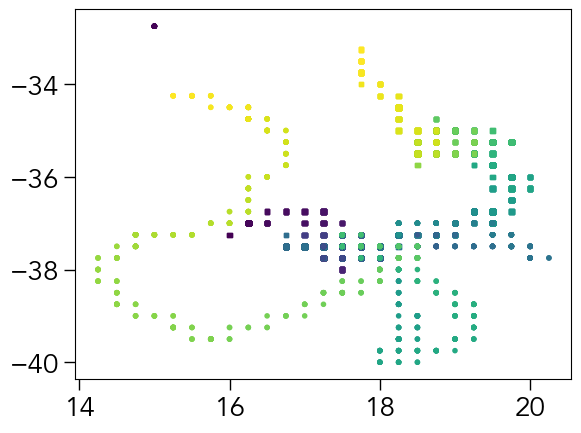

In [6]:
plt.scatter((sbk_1h['longitude'].values*4).round(0)/4,(sbk_1h['latitude'].values*4).round(0)/4,c=sbk_1h['time'].values, marker='s', s=10)
plt.scatter((sbpp_1h['longitude'].values*4).round(0)/4,(sbpp_1h['latitude'].values*4).round(0)/4,c=sbpp_1h['time'].values, marker='.')

In [7]:
dl = 5  # Grid size parameter

lat  = (sbk_1h['latitude'].values*4).round(0)/4
lon  = (sbk_1h['longitude'].values*4).round(0)/4
time = sbk_1h['time'].values

# Create an empty array to store the ERA5 temperature data
era5grid = []
era5var = np.zeros(( len(time),2 * dl * 4 + 1, 2 * dl * 4 + 1))

# Iterate over the time values in the hourly Sailbuoy dataset
for i in tqdm(range(len(time)),f"Extracting a {2*dl}°x{2*dl}° grid around the Sailbuoy's hourly position"):
    
    # Retrieve the ERA5 data for the corresponding time, longitude, and latitude
    era5_data = era5.sel(time=time[i])
    era5_data = era5_data.sel(longitude=slice(lon[i] - dl, lon[i] + dl)).sel(latitude=slice(lat[i] + dl, lat[i] - dl))
    
    # Store the ERA5 data in the era5temp array
    era5grid.append(era5_data[['latitude','longitude']])
    era5var[i,:,:] = era5_data['t2m'].values

Extracting a 10°x10° grid around the Sailbuoy's hourly position:   0%|          | 0/1409 [00:00<?, ?it/s]

In [9]:
def corr_ds(ds,var,dl):
    
    dl = dl  # Grid size parameter

    lat  = (ds['latitude'].values*4).round(0)/4
    lon  = (ds['longitude'].values*4).round(0)/4
    time = ds['time'].values
    
    nx = 2 * dl * 4 + 1 
    ny = 2 * dl * 4 + 1
    nt = len(time)
    
    # Create an empty array to store the ERA5 temperature data
    era5grid = []
    era5var = np.zeros((nt, nx, ny))

    # Iterate over the time values in the hourly Sailbuoy dataset
    for i in tqdm(range(nt),f"Extracting a {2*dl}x{2*dl} grid around the Sailbuoy's hourly position"):

        # Retrieve the ERA5 data for the corresponding time, longitude, and latitude
        era5_data = era5.sel(time=time[i])
        era5_data = era5_data.sel(longitude=slice(lon[i] - dl, lon[i] + dl)).sel(latitude=slice(lat[i] + dl, lat[i] - dl))

        # Store the ERA5 data in the era5temp array
        era5grid.append(era5_data[['longitude','latitude']])
        era5var[i,:,:] = era5_data[var].values

    grid = np.zeros(np.shape(era5var))  # Create an empty grid for storing distances
    var_corr = np.zeros(np.shape(era5var))  # Create an empty grid for storing correlation factors

    # Loop over latitude
    for i in tqdm(range(ny), desc='Latitude', total=ny):

        # Loop over longitude
        for j in tqdm(range(nx), desc='Longitude', total=nx, leave=False):

            # Loop over time
            for t in np.arange(12,nt - 12, 1):

                # Calculate the correlation factor between the center grid cell and all other grid cells
                var_corr[t, i, j], _ = stats.pearsonr(
                    era5var[t - 12: t + 13, i, j],
                    era5var[t - 12: t + 13, 
                            int((nx - 1) / 2), 
                            int((nx - 1) / 2)],
                )

                # Calculate the distance between the current point and the central point using gsw.distance
                distance = gsw.distance([lon[t+12], era5grid[t+12].isel(longitude=j)['longitude'].values], [lat[t+12], era5grid[t+12].isel(latitude=i)['latitude'].values]) / 1000

                # Store the distance in the grid array
                grid[t, i, j] = distance


    # Create xarray dataset
    correlation_ds = xr.Dataset(
        data_vars={f"{var}": (("time", "latitude", "longitude"), era5var),
                   f"{var}_correlation": (("time", "latitude","longitude"), var_corr),
                   "distance_grid": (("time", "latitude", "longitude"), grid)},
        coords={"time": time, "longitude": era5grid[0].longitude.values, "latitude": era5grid[0].latitude.values},
    )           

    # Calculate the mean of correlation factors over time
    var_corr_mean = np.mean(var_corr, axis=0)
    grid_mean = np.mean(grid, axis=0)
    
    return correlation_ds

In [ ]:
ds_t2m = corr_ds(sbk_1h,'t2m',5)
ds_wind = corr_ds(sbk_1h,'wind_speed',5)
ds_sst = corr_ds(sbk_1h,'sst',5)

In [15]:
ds_wind

NameError: name 'ds_wind' is not defined

In [8]:
ds = xr.open_dataset('decorr_dataset.nc')

In [9]:
ds

<xarray.Dataset>
Dimensions:                 (time: 1409, latitude: 41, longitude: 41)
Coordinates:
  * time                    (time) datetime64[ns] 2023-03-06T12:00:00 ... 202...
  * longitude               (longitude) float32 11.0 11.25 11.5 ... 20.75 21.0
  * latitude                (latitude) float32 -32.25 -32.5 ... -42.0 -42.25
Data variables:
    t2m                     (time, latitude, longitude) float64 ...
    t2m_correlation         (time, latitude, longitude) float64 ...
    distance_grid           (time, latitude, longitude) float64 ...
    t2mr2                   (time, latitude, longitude) float64 ...
    wind_speed              (time, latitude, longitude) float64 ...
    wind_speed_correlation  (time, latitude, longitude) float64 ...

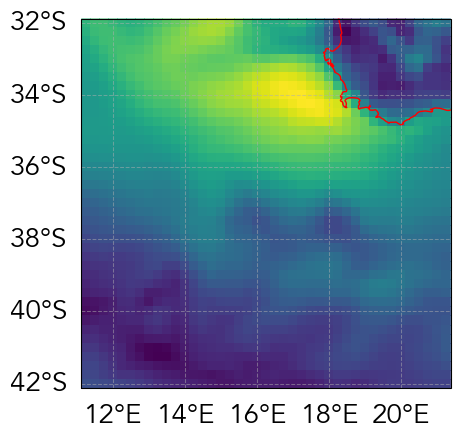

In [19]:
import cartopy.feature as cfeature
i = 15
# Create the figure and axes
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the data

ax.pcolor(era5grid[i].longitude,era5grid[i].latitude,ds['wind_speed'].isel(time=i))

# Add coastlines
ax.add_feature(cfeature.COASTLINE, edgecolor='r')

gridlines(ax,2,2)

# Show the plot
plt.show()

Interesting time stamps

In [340]:
ts = [371,718,872,967,1133,1352]

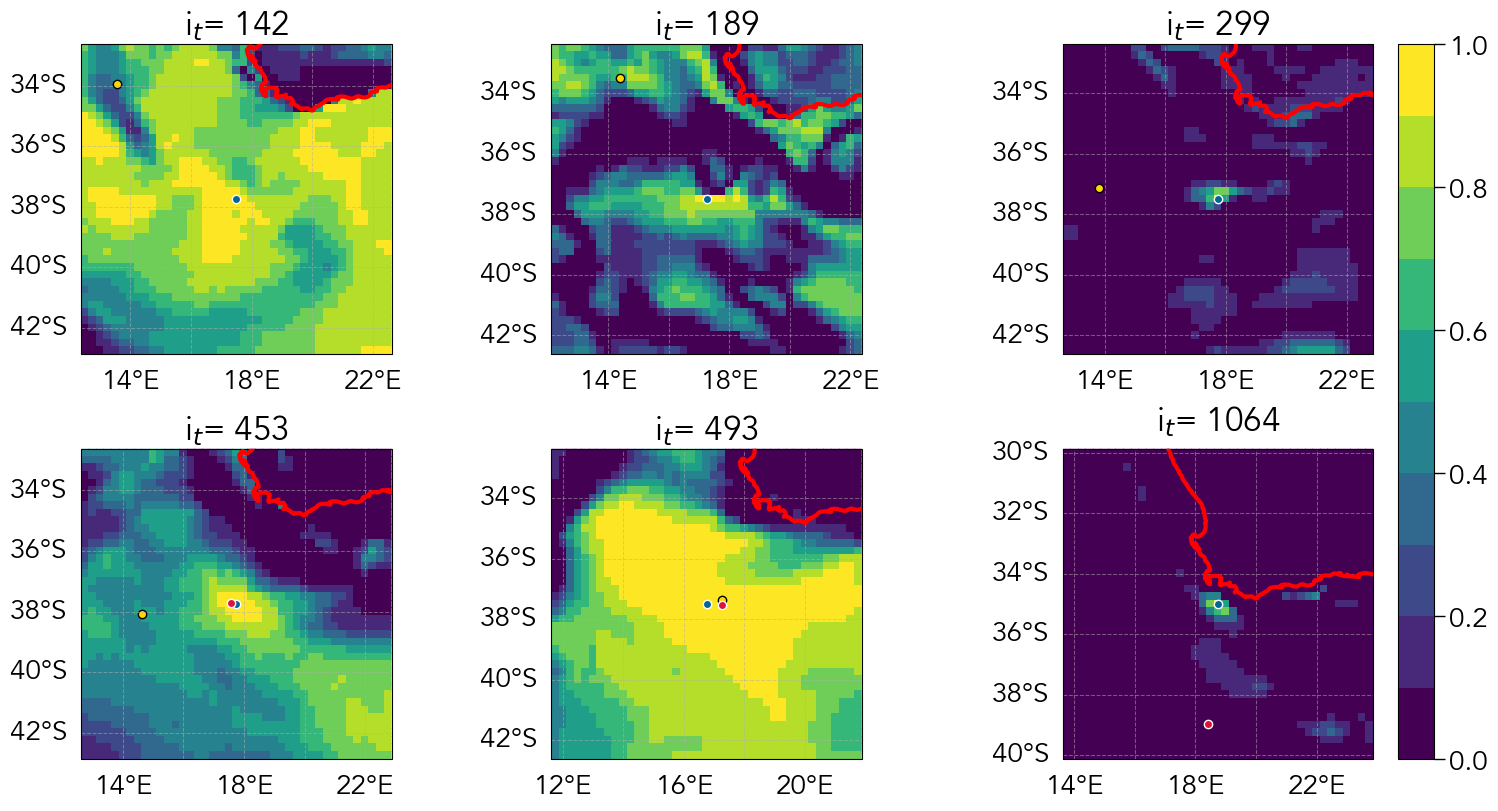

In [28]:
ts = [142,189,299,453,493,1064] #1279

# Create the figure and axes
fig, ax = plt.subplots(2,int(len(ts)/2),subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(5*len(ts)/2,8),constrained_layout=True)

ax = ax.flatten()

for i,t in enumerate(ts):

    # Plot the data
    pcm = ax[i].pcolor(era5grid[t].longitude, era5grid[t].latitude, ds.t2mr2.isel(time=t)**2,  vmin=0, vmax=1, cmap=plt.get_cmap('viridis', 10))
    ax[i].scatter(0.5,0.5,c=kc,ec='w',transform=ax[i].transAxes)

    if ds.time.isel(time=ts[i]).values in ship.time.values:
        ax[i].scatter(ship.sel(time=ds.time.isel(time=ts[i]).values).LO,ship.sel(time=ds.time.isel(time=ts[i]).values).LA,c='gold',ec='k')
    
    if ds.time.isel(time=ts[i]).values in sb_pp.time.values:
        ax[i].scatter(sb_pp.sel(time=ds.time.isel(time=ts[i]).values).longitude,sb_pp.sel(time=ds.time.isel(time=ts[i]).values).latitude,c=ppc,ec='w')
    
    # Add coastlines
    ax[i].add_feature(cfeature.COASTLINE, edgecolor='r', zorder=3, lw=3)
    ax[i].set_title(r'i$_t$= ' + f'{t}')
    gridlines(ax[i],2,2)

plt.colorbar(pcm,ax=[ax[2],ax[5]])
# Show the plot
plt.show()


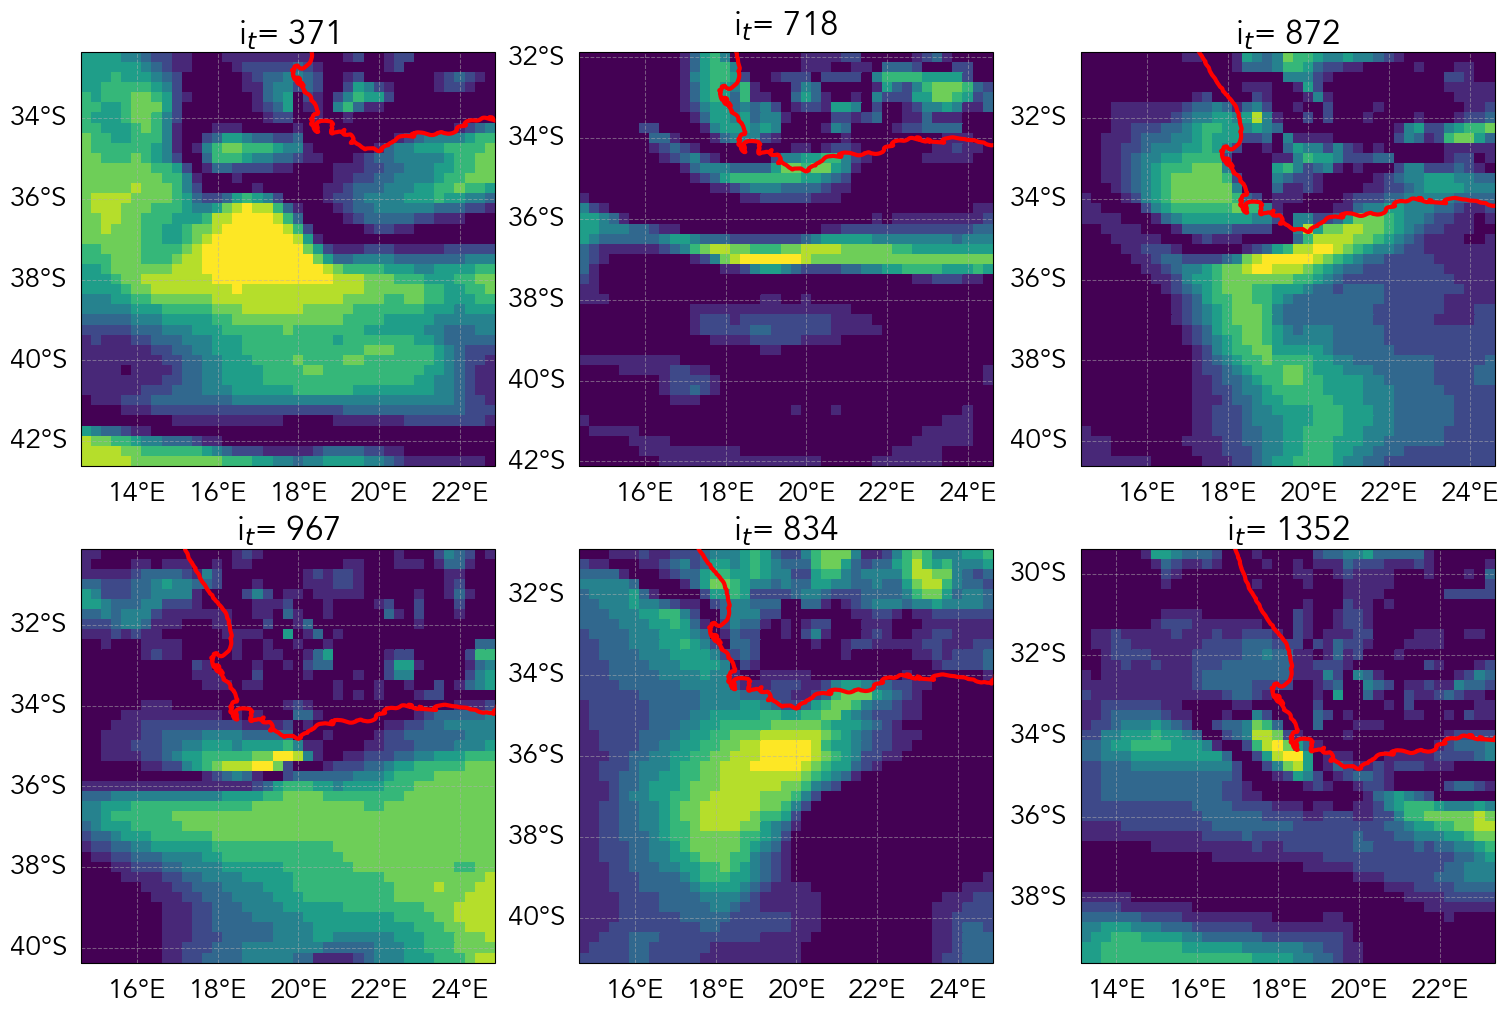

In [343]:
#import cartopy.feature as cfeature

ts = [371,718,872,967,834,1352]

# Create the figure and axes
fig, ax = plt.subplots(2,int(len(ts)/2),subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(5*len(ts)/2,10),constrained_layout=True)

ax = ax.flatten()

for i,t in enumerate(ts):

    # Plot the data
    ax[i].pcolor(era5grid[t].longitude, era5grid[t].latitude, ds.wind_speed_correlation.isel(time=t)**2,  vmin=0, vmax=1, cmap=plt.get_cmap('viridis', 10))

    # Add coastlines
    ax[i].add_feature(cfeature.COASTLINE, edgecolor='r', zorder=3, lw=3)
    ax[i].set_title(r'i$_t$= ' + f'{t}')
    gridlines(ax[i],2,2)

# Show the plot
plt.show()


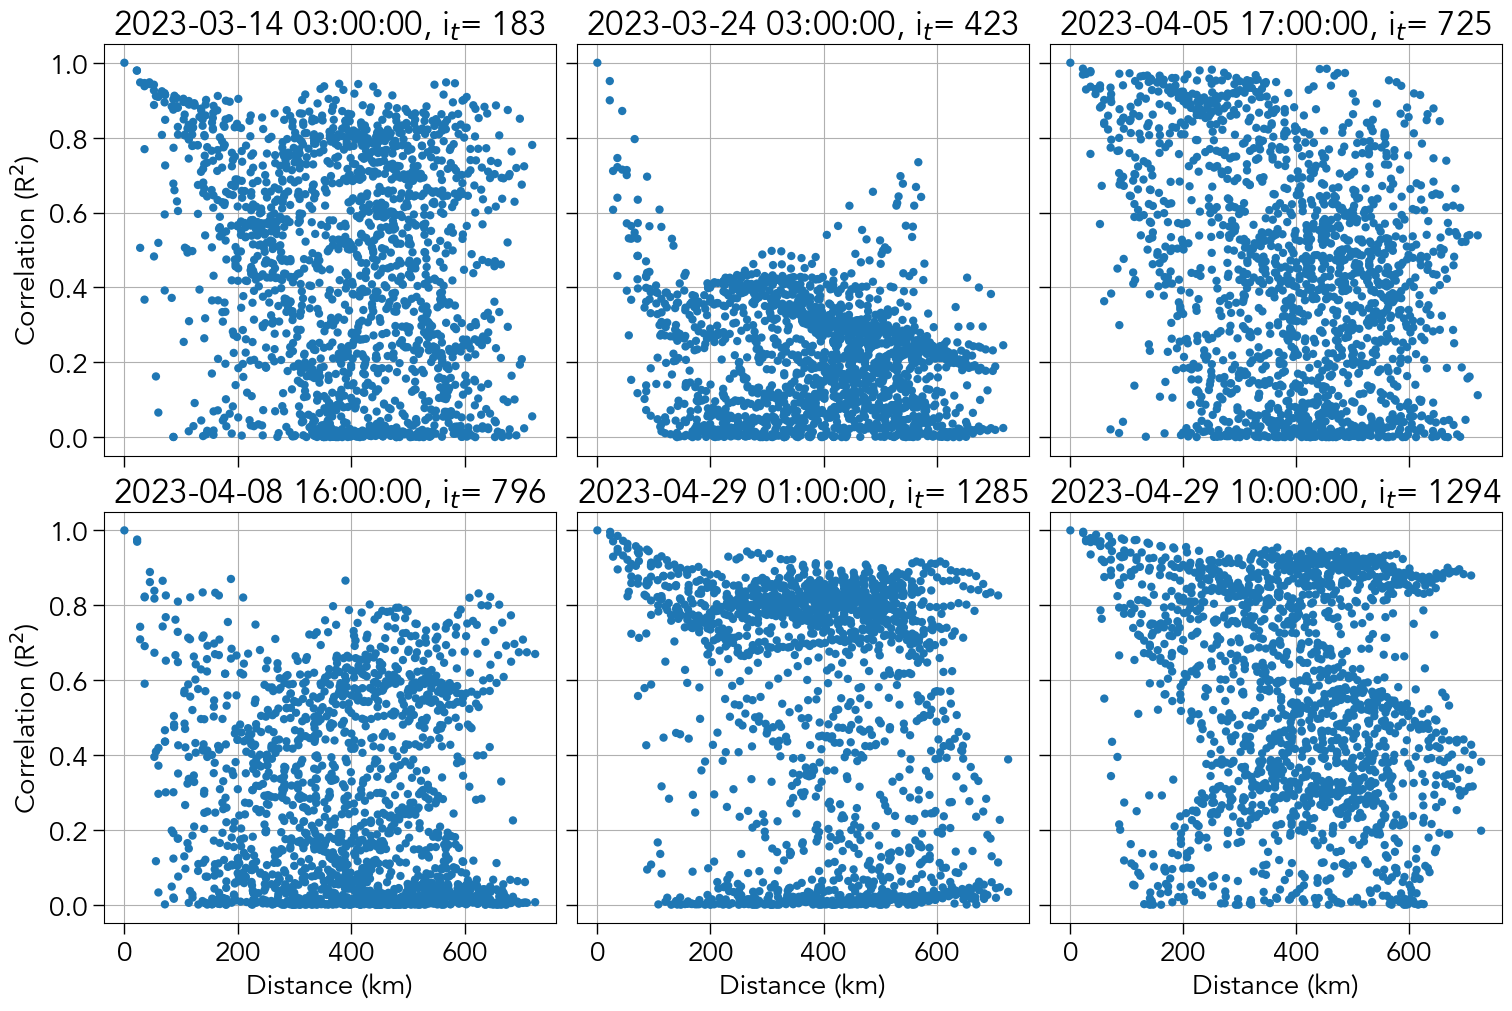

In [358]:
c = 3
r = 2

fig, ax = plt.subplots(r,c,figsize=(5*c, 5*r),constrained_layout=True,sharex='col',sharey='row')

ax = ax.flatten()

n = np.sort(np.random.randint(0,len(ds.time.values),6))

for i,m in enumerate(n):
    ds.isel(time=m).plot.scatter(x='distance_grid',y='t2mr2',ec=None,ax=ax[i],zorder=2)
    ax[i].set(title=str(pd.to_datetime(ds.isel(time=m).time.values)) + r', i$_t$= ' + f'{m}')
    ax[i].grid(zorder=1)
    
    if i % c == 0:
        ax[i].set(ylabel='Correlation (R$^{2}$)')
    else:
        ax[i].set(ylabel='')

    if i > r*c-c-1:
        ax[i].set(xlabel='Distance (km)')
    else:
        ax[i].set(xlabel='')

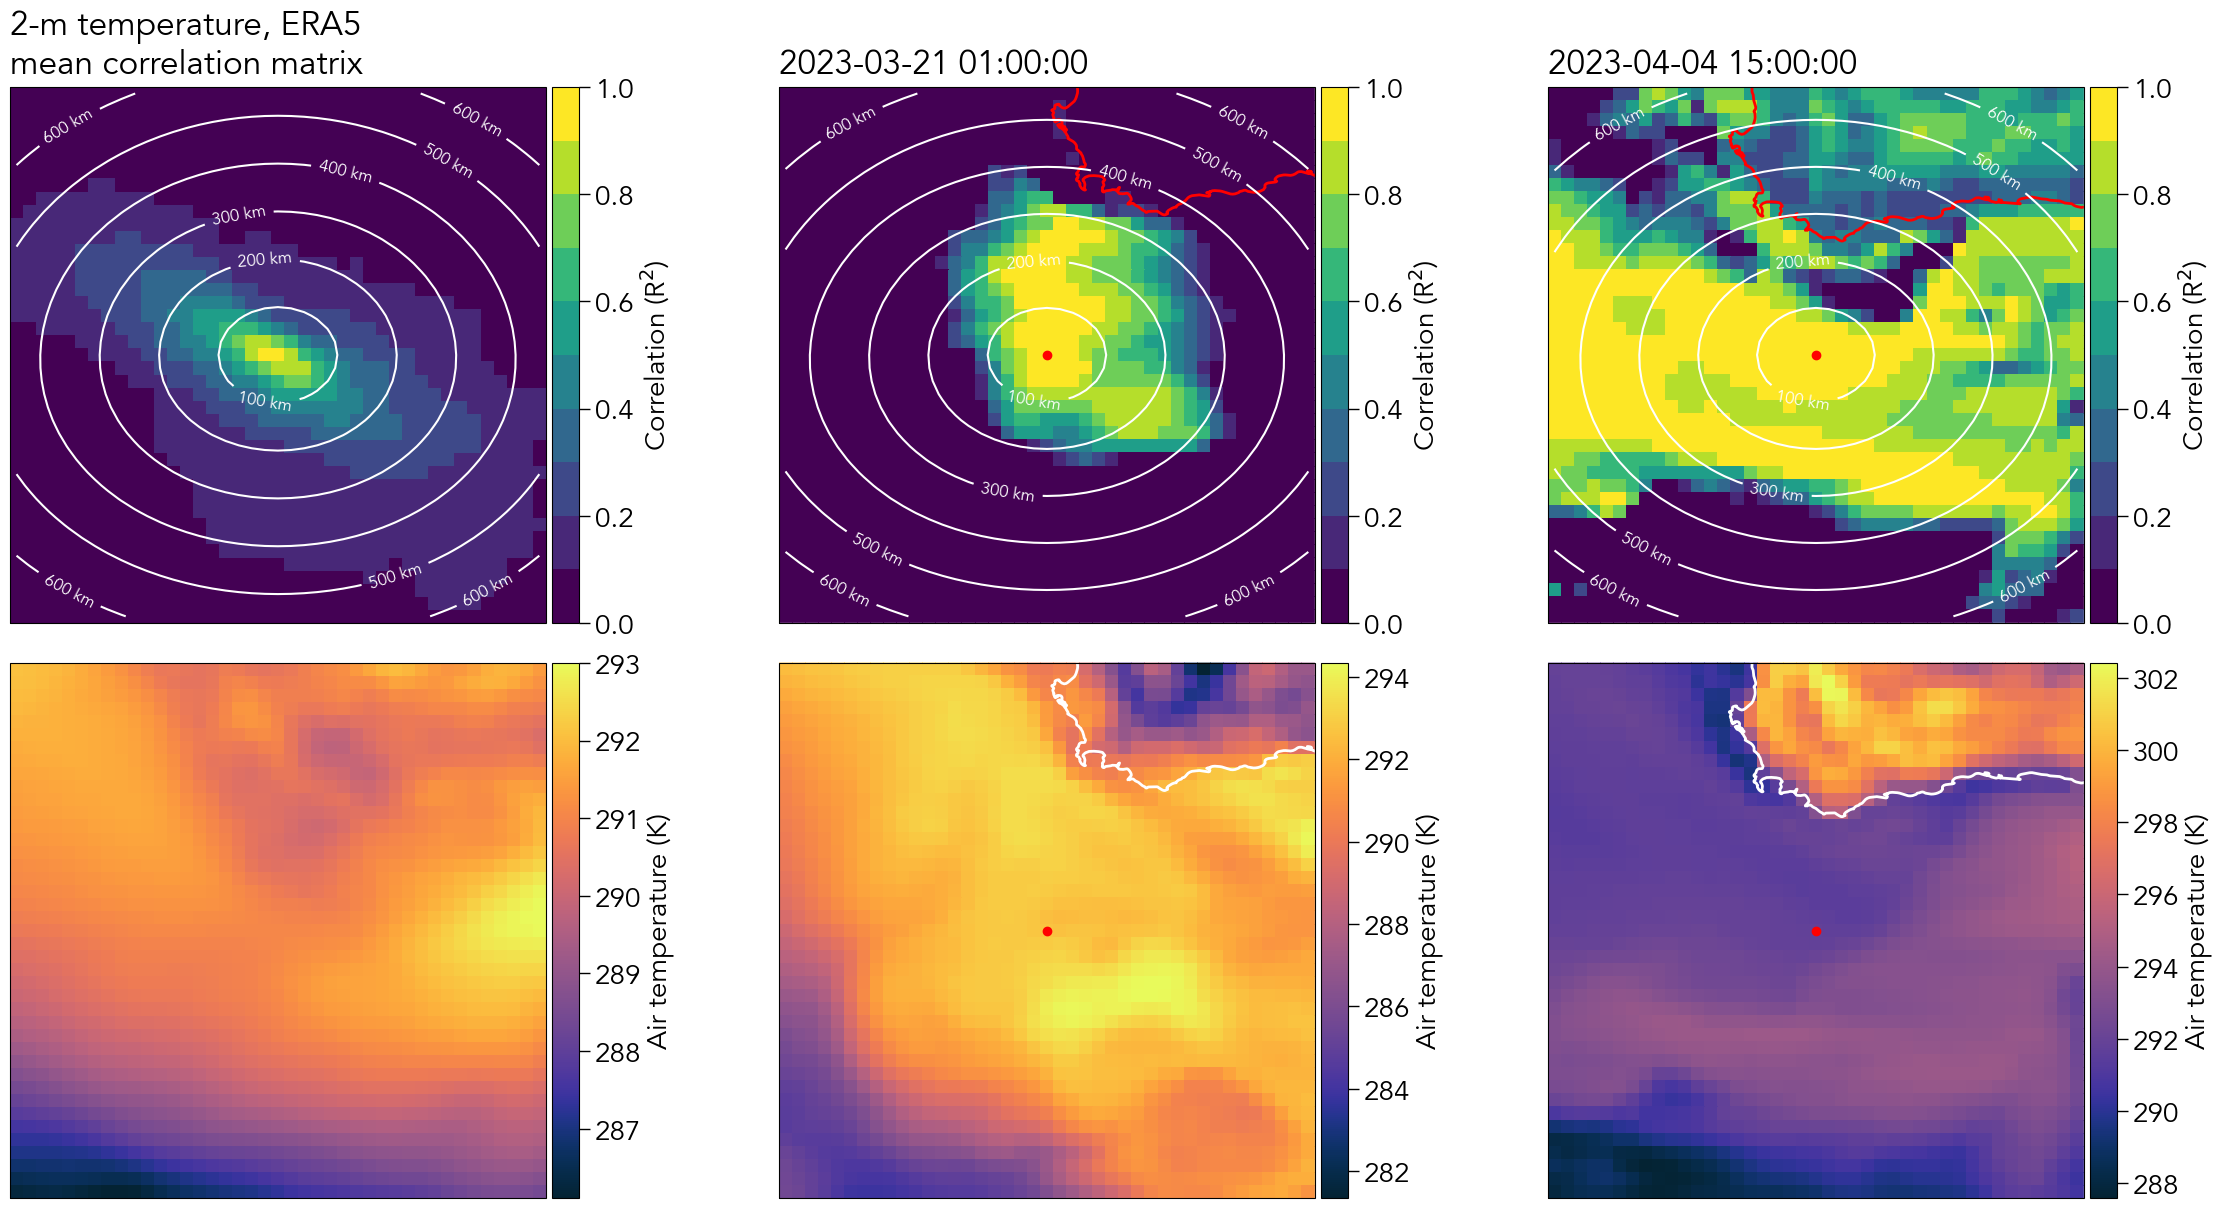

In [277]:
# Create the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(23, 12), subplot_kw=dict(projection=ccrs.PlateCarree()), constrained_layout=True)

# Flatten the axes for easy iteration
ax = ax.flatten()

# Define the time indices for specific plots
a = 350
b = 700
dl = 5

for i,axs in enumerate(ax[:3]):
    
    if i == 0:
        # Plot mean correlation matrix for 2-m temperature
        pcm = (ds['t2m_correlation'][12:-12].mean('time')**2).plot(x='longitude', vmin=0, vmax=1, cmap=plt.get_cmap('viridis', 10), ax=axs, add_colorbar=False)
        plt.colorbar(pcm,ax=axs,label='Correlation (R$^{2}$)', pad=0.01)

        cnt = axs.contour(ds.longitude, ds.latitude, ds.distance_grid.mean('time'), levels=np.arange(0, 601, 100), colors='w')
        pcm = ds['t2m'].mean('time').plot(x='longitude', cmap=cmo.thermal, ax=ax[i+3], add_colorbar=False)
        plt.colorbar(pcm,ax=ax[i+3],label='Air temperature (K)', pad=0.01)

    else:
        
        pcm = axs.pcolor(era5grid[[a,b][i-1]].longitude, era5grid[[a,b][i-1]].latitude, ds.t2m_correlation.isel(time=[a,b][i-1]),  vmin=0, vmax=1, cmap=plt.get_cmap('viridis', 10))
        cnt = axs.contour(era5grid[[a,b][i-1]].longitude, era5grid[[a,b][i-1]].latitude, ds.distance_grid.isel(time=[a,b][i-1]), levels=np.arange(0, 601, 100), colors='w')
        plt.colorbar(pcm,ax=axs,label='Correlation (R$^{2}$)', pad=0.01)
        
        
        pcm = ax[i+3].pcolor(era5grid[[a,b][i-1]].longitude, era5grid[[a,b][i-1]].latitude, ds.t2m.isel(time=[a,b][i-1]), cmap=cmo.thermal)
        plt.colorbar(pcm,ax=ax[i+3],label='Air temperature (K)', pad=0.01)

        
        axs.coastlines(color='red',lw=2)
        ax[i+3].coastlines(color='w',lw=2)
        axs.scatter(era5grid[[a,b][i-1]].longitude[int(((2 * dl * 4 + 1) - 1) / 2)],era5grid[[a,b][i-1]].latitude[int(((2 * dl * 4 + 1) - 1) / 2)],c='r')
        ax[i+3].scatter(era5grid[[a,b][i-1]].longitude[int(((2 * dl * 4 + 1) - 1) / 2)],era5grid[[a,b][i-1]].latitude[int(((2 * dl * 4 + 1) - 1) / 2)],c='r')

    # Add contour labels
    contour_labels = axs.clabel(cnt, inline=True, fontsize=12, colors='w', inline_spacing=15)

    # Modify contour labels
    for label in contour_labels:
        label.set_text(f'{label.get_text()} km')


    axs.set_title(['2-m temperature, ERA5\nmean correlation matrix',pd.to_datetime(time[a]),pd.to_datetime(time[b])][i],loc='left',y=1.01)
    axs.set_title('',loc='center',y=1.01)

plt.show()

In [55]:
for a,t in tqdm(enumerate(ds.time)):
    # Create the figure and axes
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection=ccrs.PlateCarree()), constrained_layout=True)

    # Define the time indices for specific plots
    dl = 5

    for i,axs in enumerate(ax):

        pcm = axs.pcolor(era5grid[a].longitude, era5grid[a].latitude, [ds.t2m_correlation.isel(time=a),ds.t2m.isel(time=a)][i],  vmin=[0,np.percentile(ds.t2m,5)][i], vmax=[1,np.percentile(ds.t2m,95)][i], cmap=[plt.get_cmap('viridis', 10),cmo.thermal][i])
        cnt = axs.contour(era5grid[a].longitude, era5grid[a].latitude, ds.distance_grid.isel(time=a), levels=np.arange(0, 601, 100), colors='w')
        plt.colorbar(pcm,ax=axs,label=['Correlation (R$^{2}$)', 'Temperature (K)'][i], pad=0.01)

        axs.coastlines(color=['red','w'],lw=2)
        axs.scatter(era5grid[a].longitude[int(((2 * dl * 4 + 1) - 1) / 2)],era5grid[a].latitude[int(((2 * dl * 4 + 1) - 1) / 2)],c='r')

        # Add contour labels
        contour_labels = axs.clabel(cnt, inline=True, fontsize=12, colors='w', inline_spacing=15)

        # Modify contour labels
        for label in contour_labels:
            label.set_text(f'{label.get_text()} km')


        axs.set_title(['2-m temperature, ERA5\ncorrelation matrix',pd.to_datetime(time[a])][i],loc='left',y=1.01)
        axs.set_title('',loc='center',y=1.01)
    plt.savefig(f'/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/figures/gifs/decorr/temp_{str(a).zfill(4)}.png')
    plt.close()

0it [00:00, ?it/s]

In [144]:
import imageio

In [142]:
def gifmaker(impath,savepath,duration):

    filenames = []
    for file in glob.glob(impath): # Specify where the images at
        filenames.append(file)
    filenames.sort(key=os.path.getmtime)

    images = list(map(lambda filename: imageio.imread(filename), filenames))

    imageio.mimsave(os.path.join(savepath), images, duration = duration) # modify duration as needed

In [95]:
gifmaker(f'/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/figures/gifs/decorr/temp_wind*.png',
             f'/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/figures/wind_correlation.gif',
             0.1)

/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_5278/2352723904.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


In [ ]:
gifmaker(f'/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/figures/gifs/decorr/temp_*.png',
             f'/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/figures/wind_correlation.gif',
             0.1)

In [ ]:
temp_correlation

In [145]:
gifmaker(f'/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/figures/gifs/decorr/temp_*.png',
             f'/Users/xedhjo/Documents/Projects/2023_Validating_Sailbuoy/figures/temp_correlation.gif',
             0.1)

/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_18944/2352723904.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


In [10]:
ship_lon = ship.isel(time=np.arange(0,3627,6))['LO']
ship_lat = ship.isel(time=np.arange(0,3627,6))['LA']
ship_t = ship.isel(time=np.arange(0,3627,6))['time']

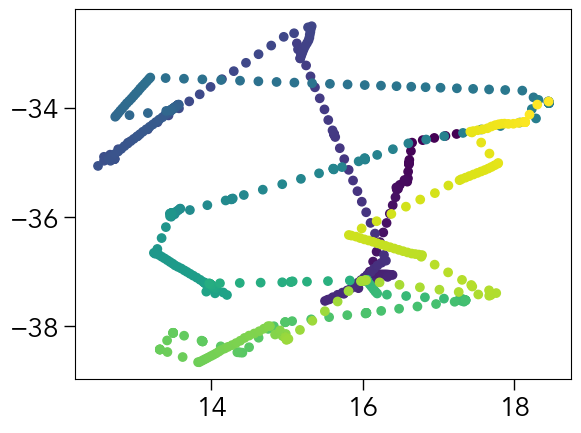

In [11]:
plt.scatter(ship_lon,ship_lat,c=ship_t)

In [12]:
mt = [time for time in ds.time.values if time in ship_t.time.values]
mi = [np.where(ship_t.time.values == time)[0][0] for time in mt]

In [13]:
test = ds.sel(time=mt).sel(longitude=(ship_lon[mi].values*4).round(0)/4).sel(latitude=(ship_lat[mi].values*4).round(0)/4)

In [14]:
ship_corr = ds.sel(time=mt)

# Assuming your 3D dataset is named 'ds'
# 'lat_values' is a list of latitudes you want to extract
# 'lon_values' is a list of longitudes you want to extract

# Create an empty list to store the extracted data for each coordinate
extracted_data = []
i = 0
for lat, lon in zip(ship_lat[mi], ship_lon[mi]):
    # Use the 'sel' method to extract data for the specific latitude and longitude
    extracted = ship_corr.sel(longitude=(lon.values*4).round(0)/4).sel(latitude=(lat.values*4).round(0)/4).isel(time=i)
    i+=1
    # Append the extracted data to the list
    extracted_data.append(extracted)

# Combine the extracted data into a new xarray dataset
ship_corr = xr.concat(extracted_data, dim='time')
ship_corr = ship_corr.isel(time=slice(12,-1))

In [15]:
ship_corr['wscr2'] = ship_corr['wind_speed_correlation']**2

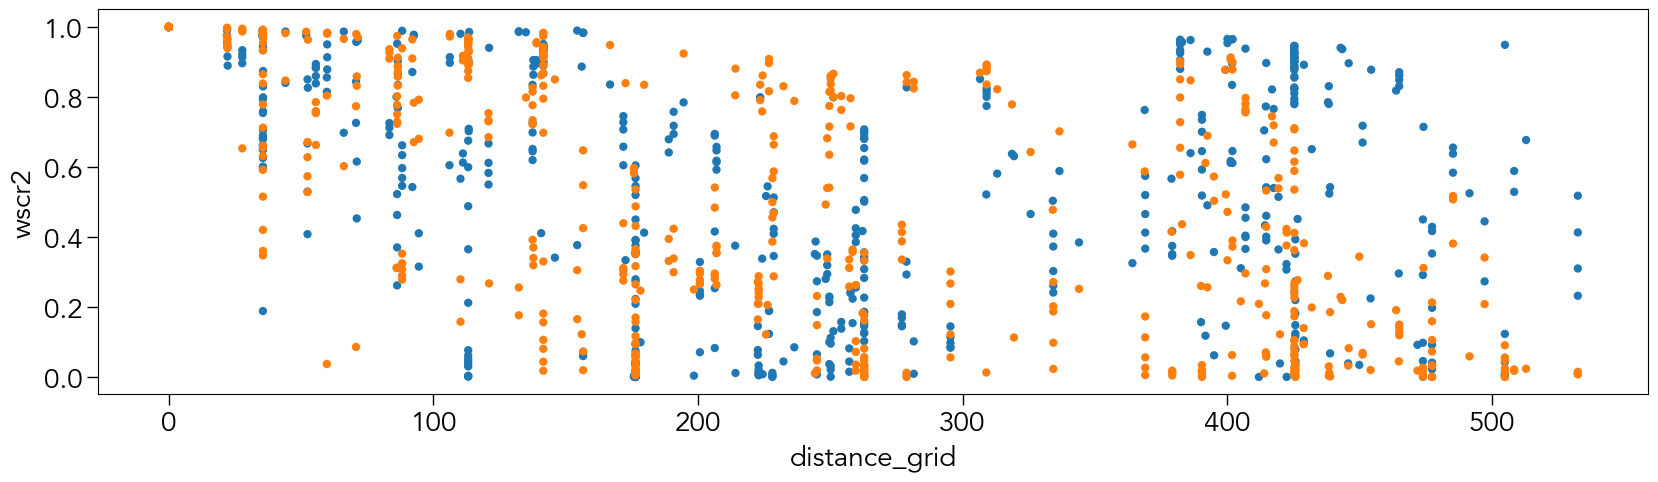

In [16]:
fig,ax = plt.subplots(figsize=(20,5))
ship_corr.plot.scatter(x='distance_grid',y='t2mr2',ec=None,alpha=1,ax=ax)
ship_corr.plot.scatter(x='distance_grid',y='wscr2',ec=None,alpha=1,ax=ax)

In [17]:
mt = [time for time in ship.time.values if time in sbk.time.values]
mi = [np.where(sbk.time.values == time)[0][0] for time in mt]

In [18]:
ship.sel(time=mt)

<xarray.Dataset>
Dimensions:  (time: 3415)
Coordinates:
    LA       (time) float64 ...
    LO       (time) float64 ...
  * time     (time) datetime64[ns] 2023-03-06T11:20:00 ... 2023-03-30T04:20:00
    doy      (time) float64 ...
Data variables:
    t2m      (time) float64 ...
    u10      (time) float64 ...
    q2m      (time) float64 ...

In [19]:
sbk.isel(time=mi)

<xarray.Dataset>
Dimensions:         (time: 3415)
Coordinates:
  * time            (time) datetime64[ns] 2023-03-06T11:20:00 ... 2023-03-30T...
    doy             (time) float64 ...
    mday            (time) float64 ...
Data variables: (12/30)
    latitude        (time) float64 ...
    longitude       (time) float64 ...
    ttff            (time) float64 ...
    count           (time) float64 ...
    commands        (time) float64 ...
    tries           (time) float64 ...
    ...              ...
    sss             (time) float64 ...
    hrw             (time) float64 ...
    hrc             (time) float64 ...
    t2m             (time) float64 ...
    u10             (time) float64 ...
    flags           (time) object ...
Attributes: (12/24)
    title:                SB Kringla Datalogger
    summary:              Datalogger output from Sailbuoy Kringla
    conventions:          CF-1.6, ACDD-1.3
    creator_name:         Johan Edholm
    platform:             Uncrewed surface vehicle
    instrument_name:      Kringla
    ...                   ...
    time_coverate_start:  2023-02-21T13:43:11.000000000
    time_coverate_end:    2023-05-04T11:50:00.000000000
    geospatial_lat_min:   -37.933327
    geospatial_lat_max:   -33.321951
    geospatial_lon_min:   16.049747
    geospatial_lon_max:   19.96224

In [71]:
from scipy import stats

stats.linregress(ship.sel(time=mt)['u10'].interpolate_na('time'),sbk.isel(time=mi)['u10'].interpolate_na('time'))

LinregressResult(slope=0.817484323518854, intercept=3.111381173486432, rvalue=0.6262828612237139, pvalue=0.0, stderr=0.017413380997672798, intercept_stderr=0.16132090136657068)

(0.0, 24.0, 0.0, 24.0)

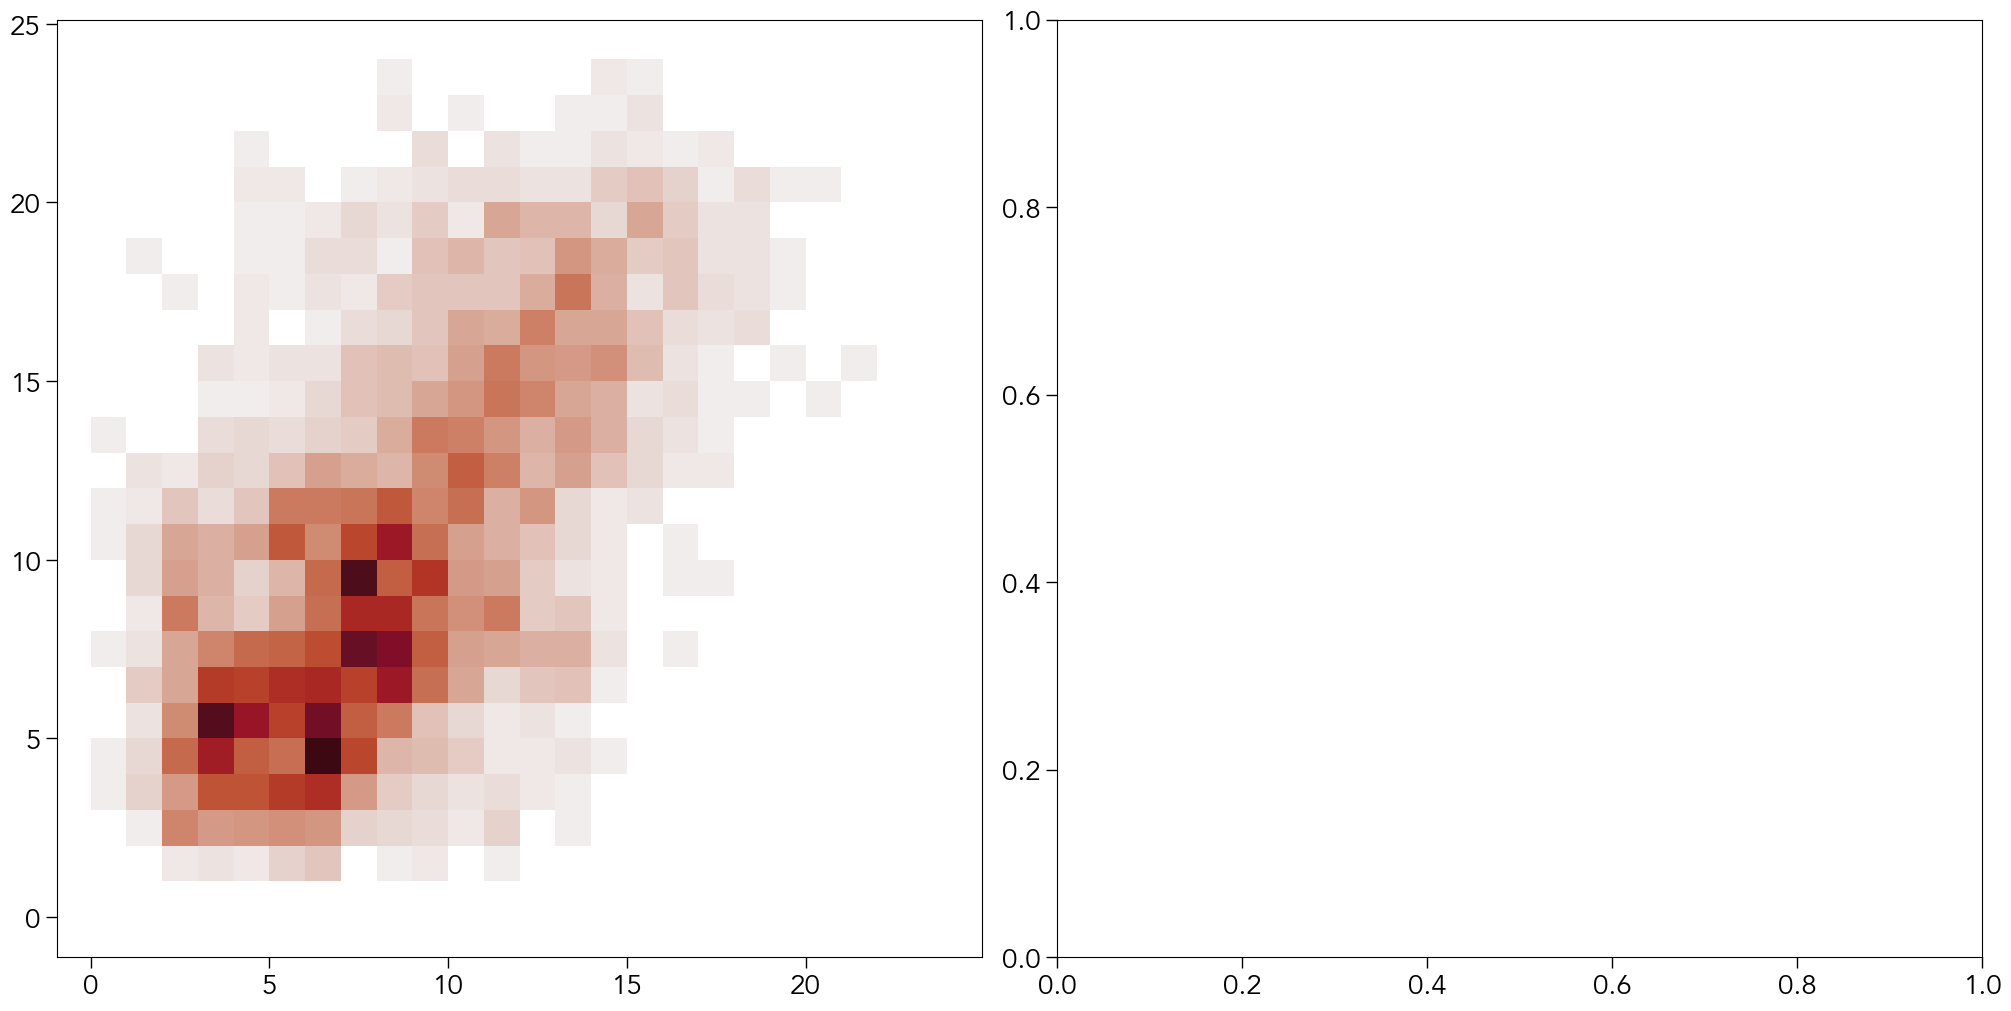

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(20,10), constrained_layout=True)

ax[0].hist2d(ship.sel(time=mt)['u10'].interpolate_na('time'),sbk.isel(time=mi)['u10'].interpolate_na('time'), bins=[np.arange(0,25,1), np.arange(0,25,1)], cmin=1, cmap=cmo.amp)
# ax[0].set(xlim=(0,25), ylim=(0,25))
ax[0].axis('equal')

In [ ]:
ship.sel(time=mt)

In [23]:
ds_corr = ship.sel(time=mt)

In [24]:
ds_corr = ds_corr.rename(dict(t2m = 't2m_ship', u10 = 'u10_ship', q2m = 'q2m_ship', LA = 'lat_ship', LO = 'lon_ship'))

In [25]:
ds_corr['t2m_sbk'] = sbk.isel(time=mi)['t2m']
ds_corr['u10_sbk'] = sbk.isel(time=mi)['u10']
ds_corr['lat_sbk'] = sbk.isel(time=mi)['latitude']
ds_corr['lon_sbk'] = sbk.isel(time=mi)['longitude']

In [26]:
import gsw_xarray as gsw

In [27]:
dist = np.zeros(len(ds_corr.time))
for i,t in enumerate(ds_corr.time.values):
    
    dist[i] = gsw.distance([ds_corr.sel(time=t)['lon_ship'],ds_corr.sel(time=t)['lon_sbk']],[ds_corr.sel(time=t)['lat_ship'],ds_corr.sel(time=t)['lat_sbk']]) / 1000

In [28]:
ds_corr['distance'] = ('time'), dist

In [120]:
ds_corr_dist = ds_corr.swap_dims({'time':'distance'}).sortby('distance')

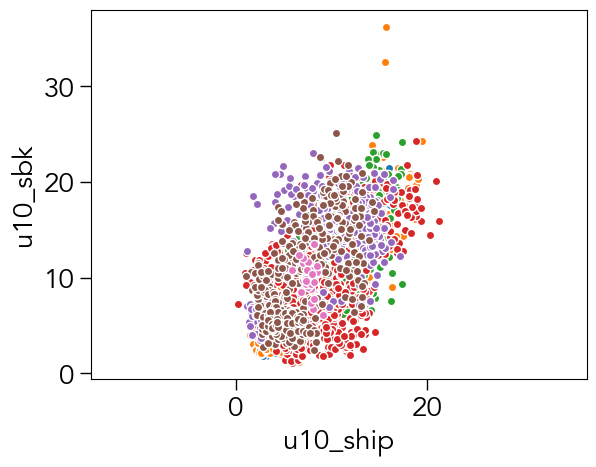

In [29]:
d=100
for i in np.arange(0,600+d,d):
    msk = (ds_corr['distance'] > i) & (ds_corr['distance'] <= i + d)
    ds_corr.where(msk,drop=True).plot.scatter(x='u10_ship', y='u10_sbk')
plt.axis('equal')
plt.show()

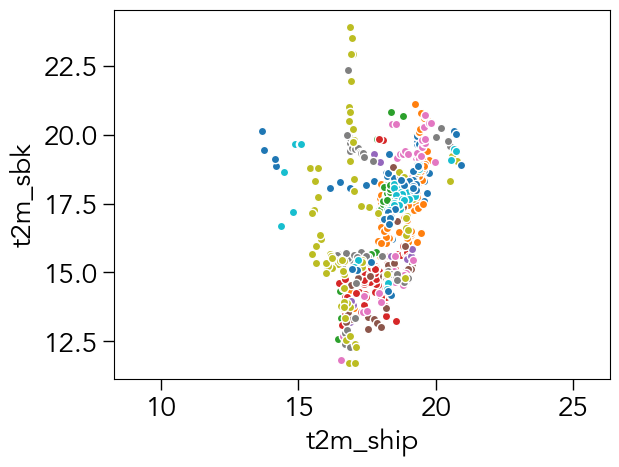

In [142]:
d=10
for i in np.arange(0,100+d,d):
    msk = (ds_corr['distance'] > i) & (ds_corr['distance'] <= i + d)
    ds_corr.where(msk,drop=True).plot.scatter(x='t2m_ship', y='t2m_sbk')
plt.axis('equal')
plt.show()

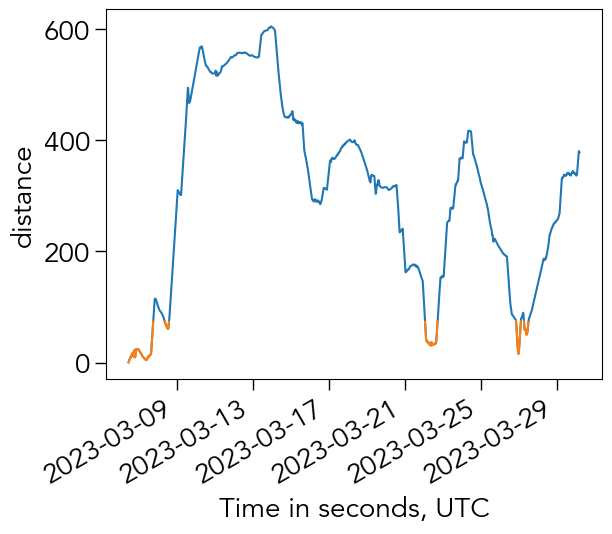

In [36]:
ds_corr['distance'].plot()
ds_corr['distance'].where(ds_corr['distance'] < 75).plot()

In [ ]:
stats.linregress(ship.sel(time=mt)['u10'].interpolate_na('time'),sbk.isel(time=mi)['u10'].interpolate_na('time'))

In [38]:
def calc_r2(ds, var1, var2):
    _,_,r,_,_ = stats.linregress(ds[var1],ds[var2])
    return r**2

In [41]:
dl = 20
d  = np.arange(0,600+dl,dl)
r2 = np.zeros(len(d))

for i,l in enumerate(d):
    msk = np.logical_and(ds_corr['distance'] > l, ds_corr['distance'] <= l + dl)
    r2[i] = (calc_r2(ds_corr.where(msk,drop=True).interpolate_na('time'),'u10_ship','u10_sbk'))

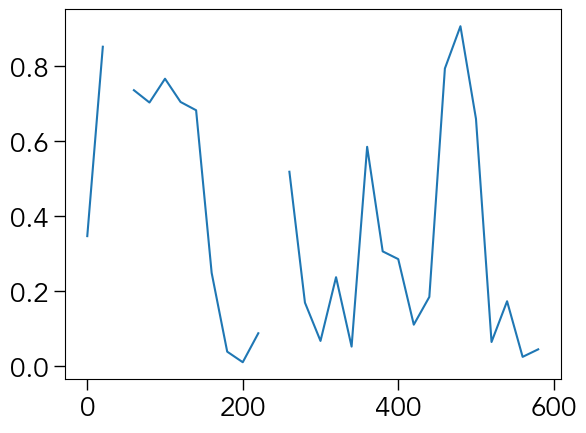

In [42]:
plt.plot(d,r2)

In [43]:
dl = 20
d  = np.arange(0,600+dl,dl)
r2 = np.zeros(len(d))

for i,l in enumerate(d):
    msk = (ds_corr['distance'] > l) & (ds_corr['distance'] <= l + dl)
    r2[i] = (calc_r2(ds_corr.where(msk,drop=True).interpolate_na('time'),'t2m_ship','t2m_sbk'))

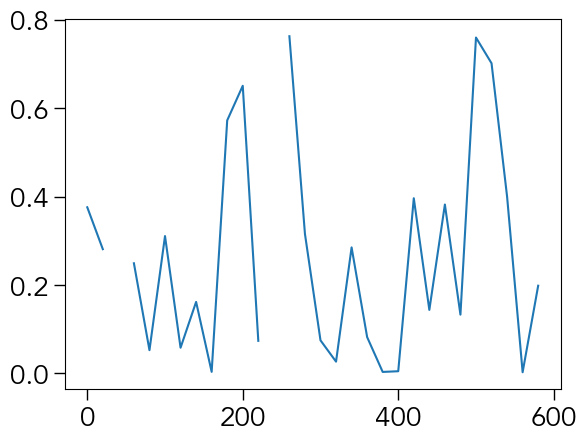

In [44]:
plt.plot(d,r2)

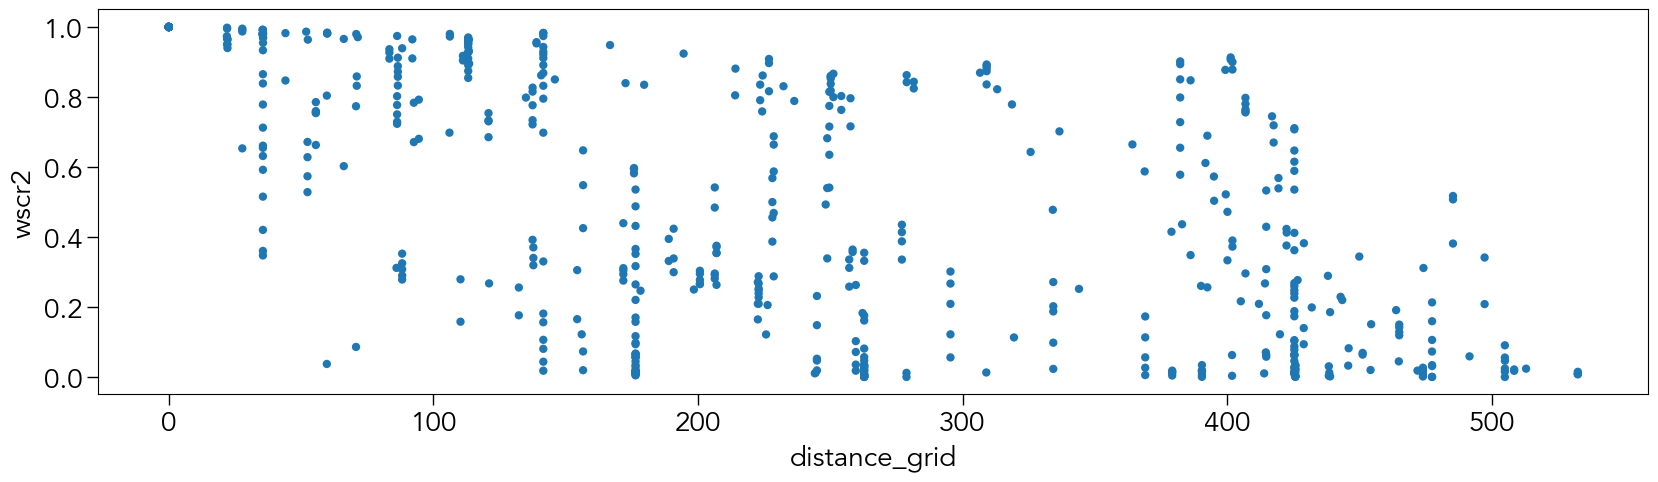

In [164]:
fig,ax = plt.subplots(figsize=(20,5))

ship_corr.plot.scatter(x='distance_grid',y='wscr2',ec=None,alpha=1,ax=ax)


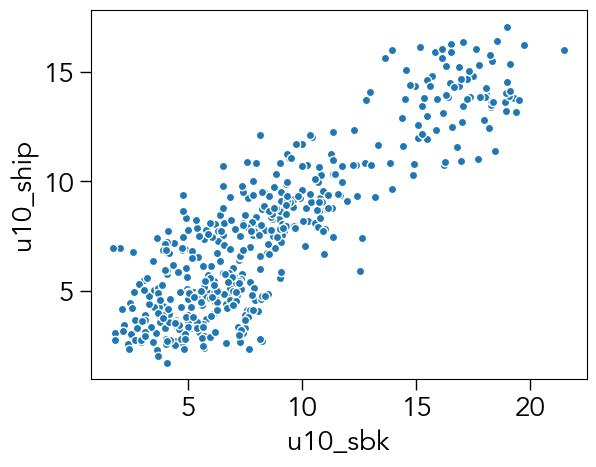

In [46]:

fig, ax = plt.subplots()

ds_corr.where(ds_corr['distance'] < 100).plot.scatter(x='u10_sbk', y='u10_ship')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Distance (km)'),
 Text(0.5, 1.0, 'Comparing observations within: 100 km')]

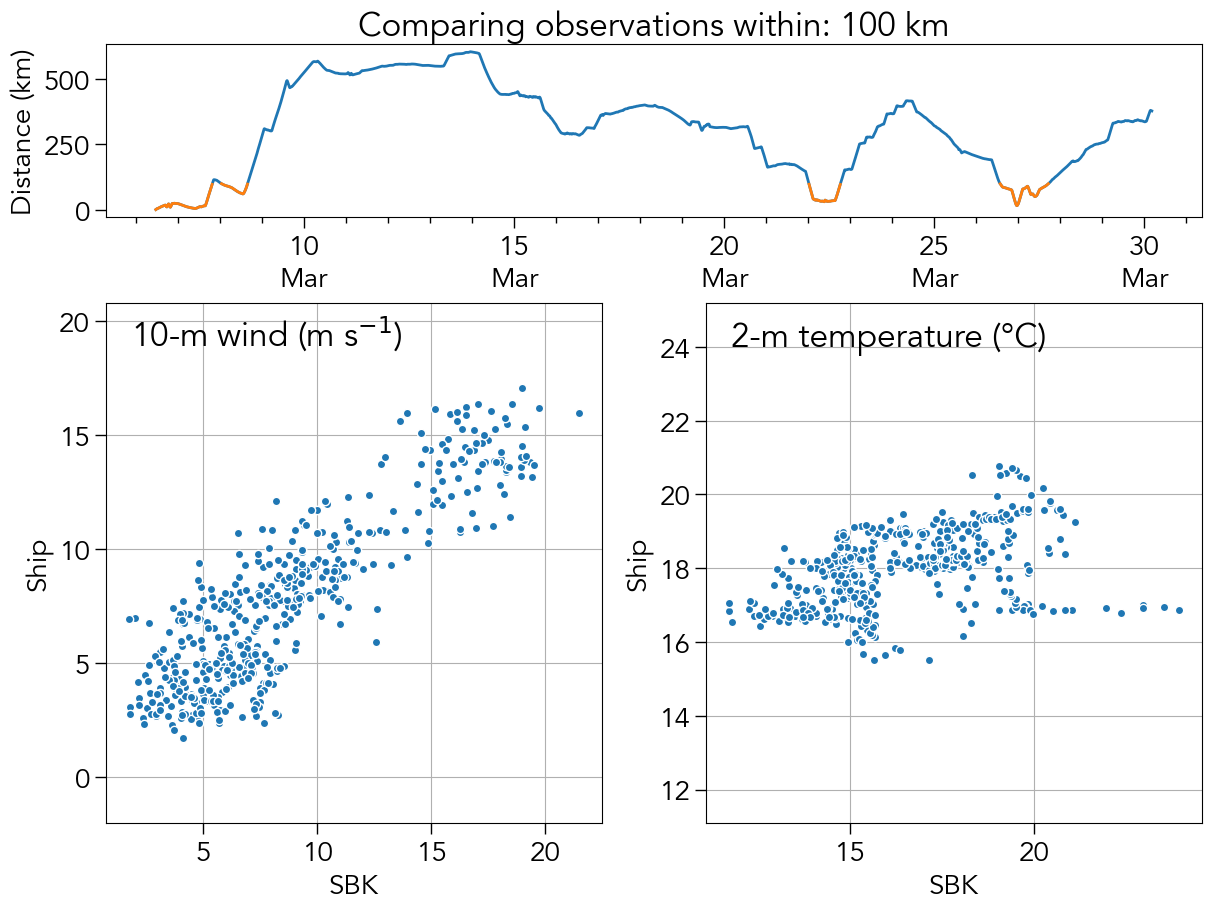

In [83]:
fig, axs = plt.subplots(ncols=2, nrows=2, gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True, figsize=(12,9))
gs = axs[0, 1].get_gridspec()
# remove the underlying axes
for ax in axs[0, :]:
    ax.remove()
top_panel = fig.add_subplot(gs[0, :])

limd = 100

ds_corr.where(ds_corr['distance'] < limd).plot.scatter(x='u10_sbk', y='u10_ship', ax=axs[1,0], zorder=2)
ds_corr.where(ds_corr['distance'] < limd).plot.scatter(x='t2m_sbk', y='t2m_ship', ax=axs[1,1], zorder=2)

for i,ax in enumerate(axs[1,:]):
    ax.axis('equal')
    ax.grid(zorder=1)
    ax.set(xlabel = 'SBK', ylabel = 'Ship')
    ax.set_title(['10-m wind (m s$^{-1}$)', '2-m temperature (°C)'][i], loc='left', y=0.9, x=0.05)
    

    
ds_corr['distance'].plot(ax=top_panel, lw=2)
ds_corr['distance'].where(ds_corr['distance'] < limd).plot(ax=top_panel, lw=2)

fix_xticks([top_panel],ds_corr)
top_panel.set(xlabel='', ylabel='Distance (km)', title = f'Comparing observations within: {limd} km')

In [86]:
(ds_corr['distance'] < limd).values

array([ True,  True,  True, ..., False, False, False])

In [ ]:
ds_corr['distance'].where(ds_corr['distance'] < limd)

In [97]:
boolean_array = (ds_corr['distance'] < limd).values

# Find the indices where True values change to False or vice versa
change_indices = np.where(np.diff(boolean_array))[0] + 1

# Split the boolean array into groups of continuous True values
groups = np.split(ds_corr['distance'].where(ds_corr['distance'] < limd).time, change_indices)

# Filter out groups with True values
time_groups = [group for group in groups if group[0]]

In [145]:
ds_corr_1 = ds_corr.sel(time=time_groups[0])
ds_corr_2 = ds_corr.sel(time=time_groups[2])
ds_corr_3 = ds_corr.sel(time=time_groups[4])
ds_corr_4 = ds_corr.sel(time=time_groups[6])

In [154]:
(mdates.date2num(ds.time[-1]) - mdates.date2num(ds.time[0]))

1.3402777777773736

In [107]:
import matplotlib.gridspec as gridspec

In [146]:
def plot_subsets(ds):
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 2])

    # Create the top two full panels
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, :],sharex=ax1)
    ax3a = plt.subplot(gs[2, 0])
    ax3b = plt.subplot(gs[2, 1])

    limd = 100

    ds.plot.scatter(x='u10_sbk', y='u10_ship', ax=ax3a, zorder=2)
    ds.plot.scatter(x='t2m_sbk', y='t2m_ship', ax=ax3b, zorder=2)

    for i,ax in enumerate([ax3a,ax3b]):
        ax.axis('equal')
        ax.grid(zorder=1)
        ax.set(xlabel = 'SBK', ylabel = 'Ship')
        ax.set_title(['10-m wind (m s$^{-1}$)', '2-m temperature (°C)'][i], loc='left', y=0.8, x=0.05)



    ds['u10_ship'].plot(ax=ax1, lw=2, c='goldenrod')
    ds['u10_sbk'].plot(ax=ax1, lw=2, c=kc)

    ds['t2m_ship'].plot(ax=ax2, lw=2, c='goldenrod')
    ds['t2m_sbk'].plot(ax=ax2, lw=2, c=kc)

    ax1.set(xlabel='', ylabel='(m s$^{-1}$)', title = f'Comparing observations within: {limd} km')
    ax2.set(xlabel='', ylabel='(°C)',)

    plt.setp(ax2.get_xticklabels(), visible=False)
    fix_xticks([ax1],ds)

    gs.tight_layout(fig)


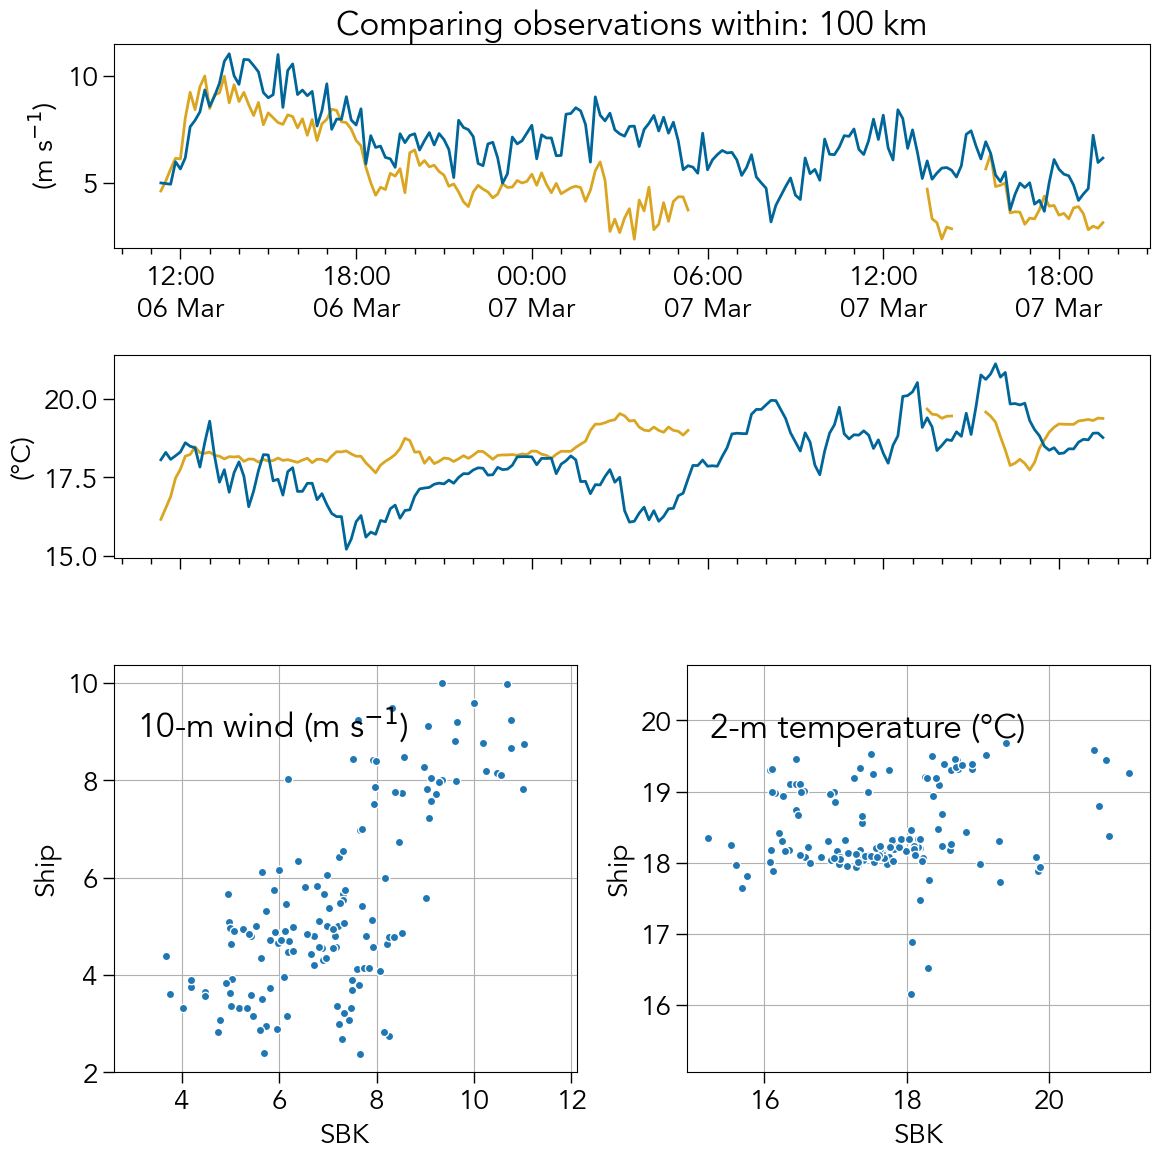

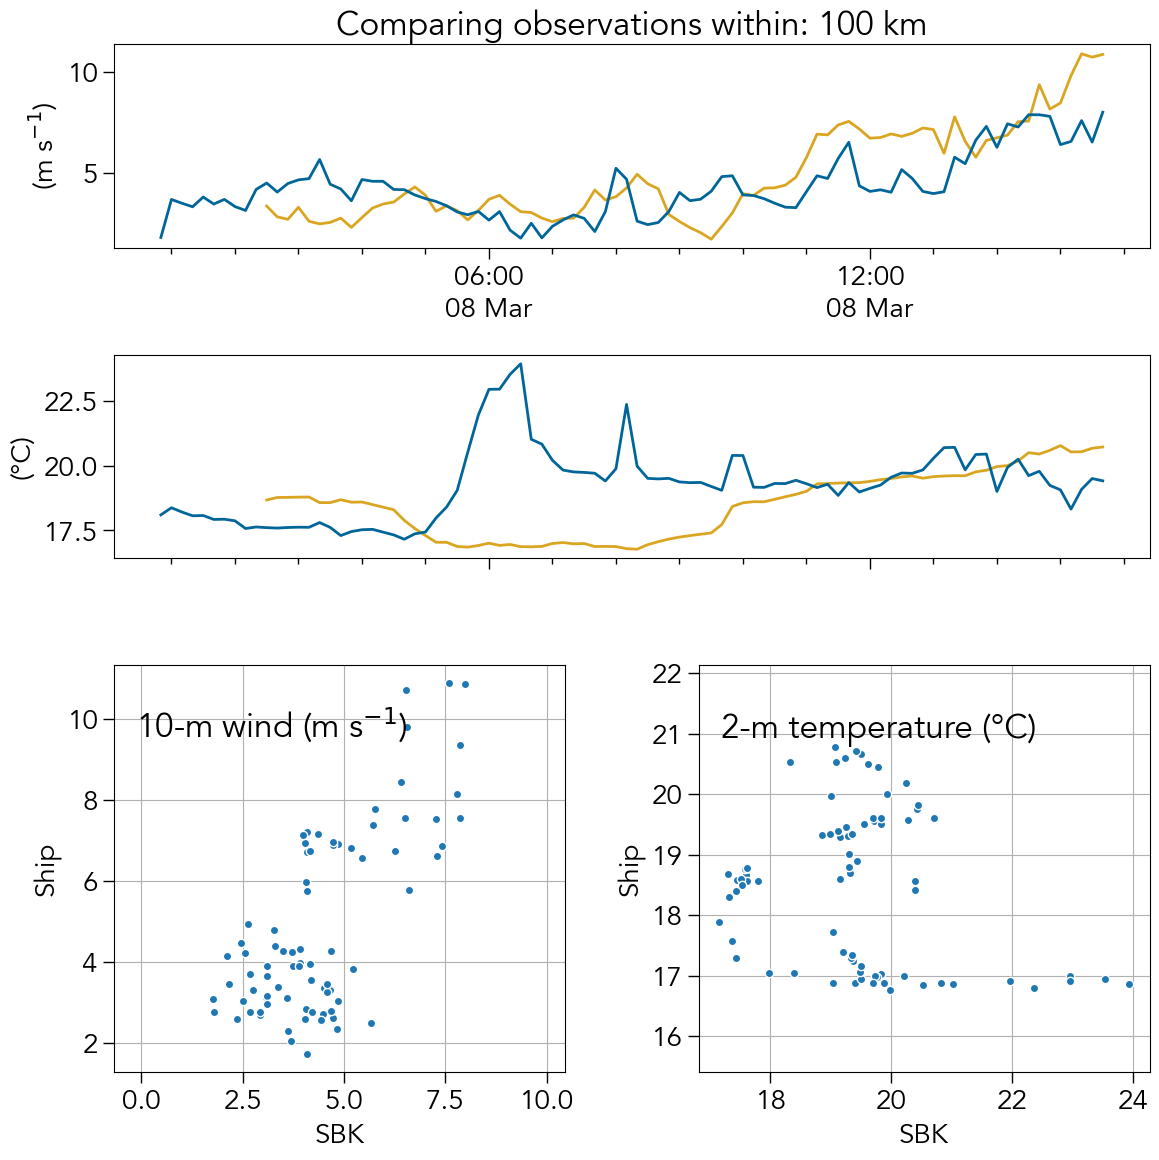

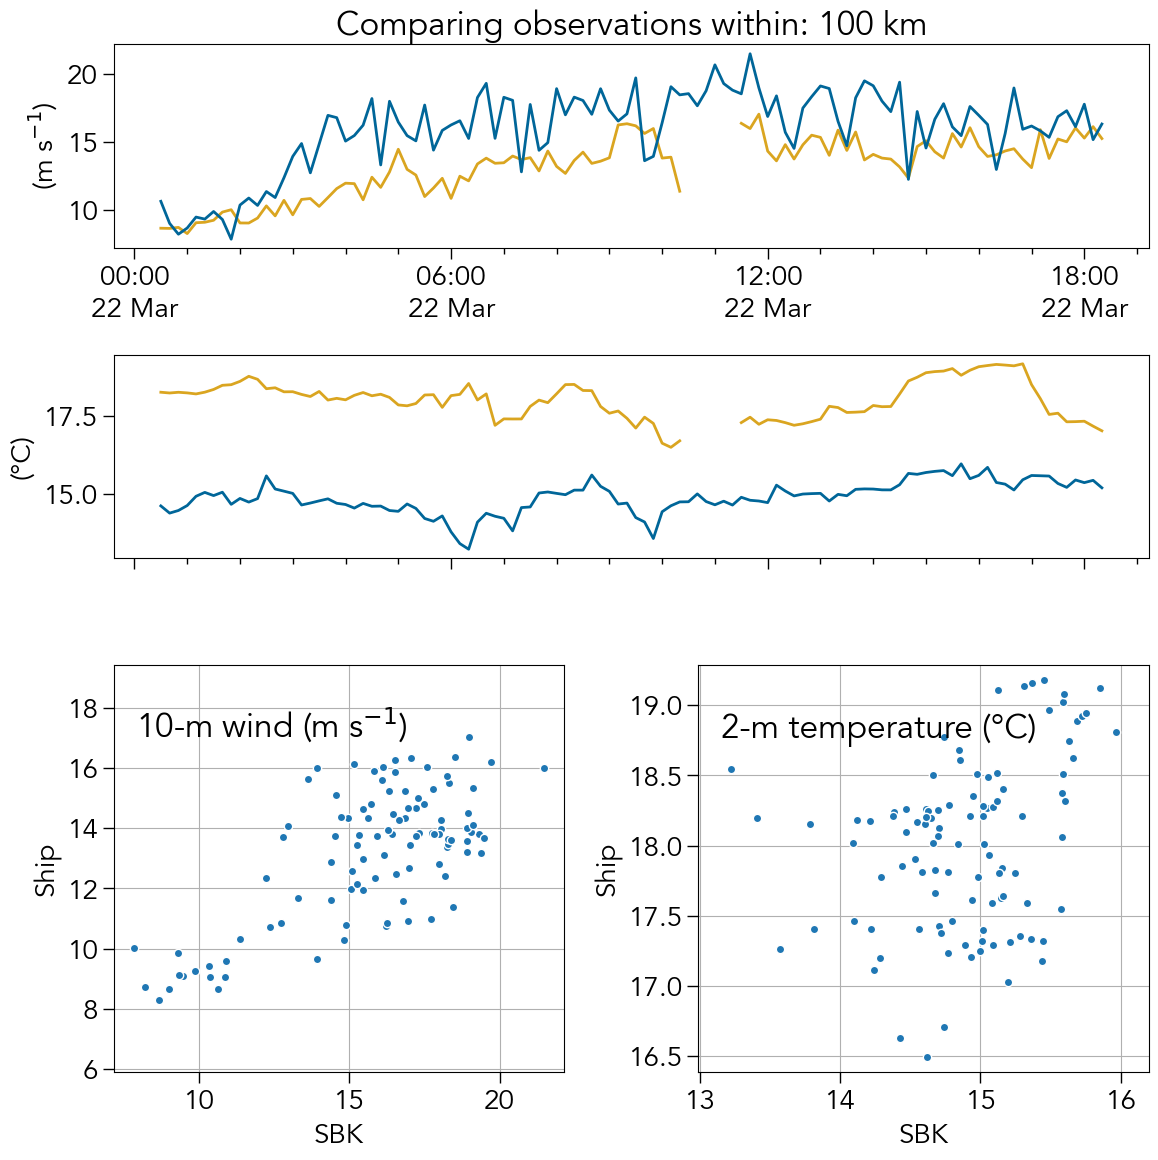

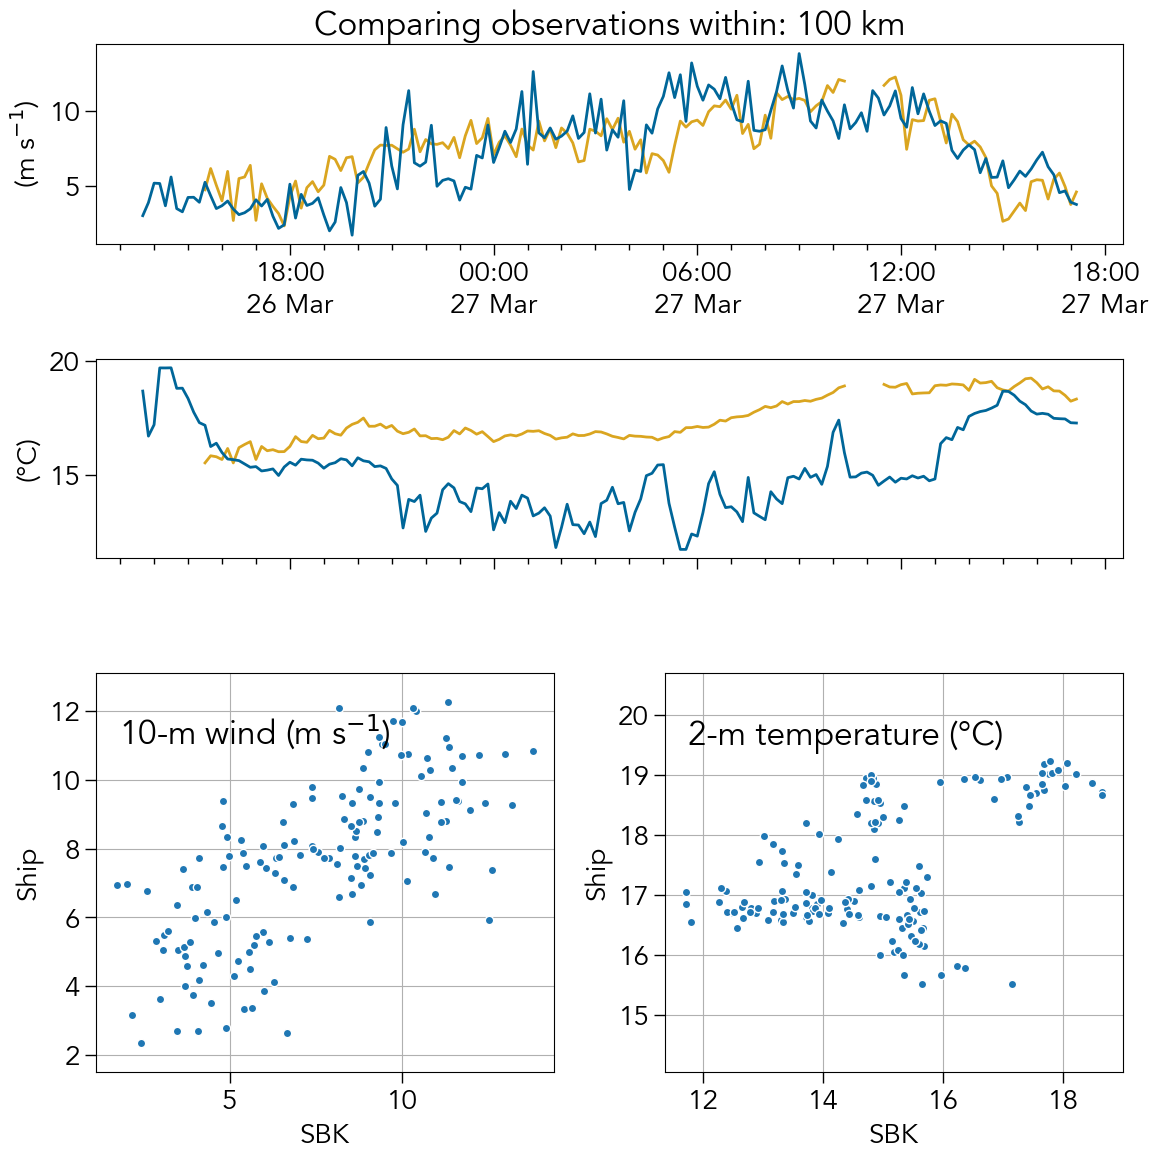

In [157]:
plot_subsets(ds_corr_1)
plot_subsets(ds_corr_2)
plot_subsets(ds_corr_3)
plot_subsets(ds_corr_4)

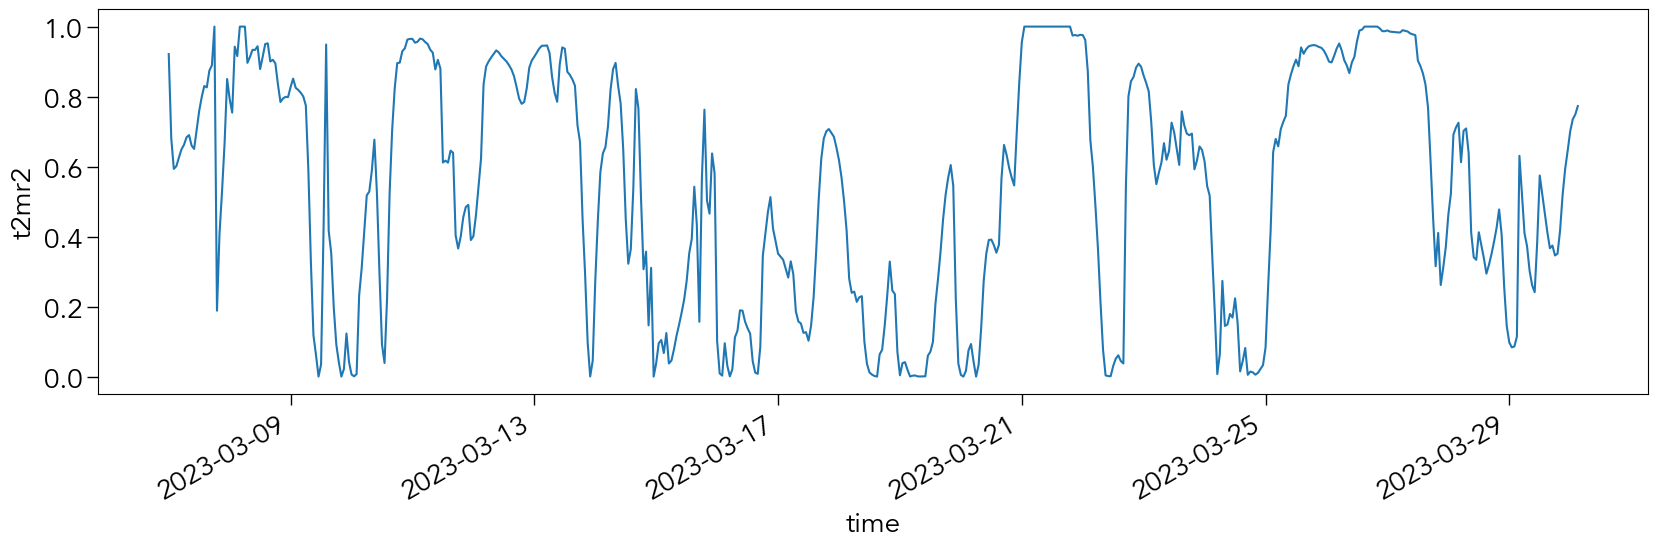

In [38]:
fig,ax = plt.subplots(figsize=(20,5))
ship_corr['t2mr2'].plot(ax=ax)

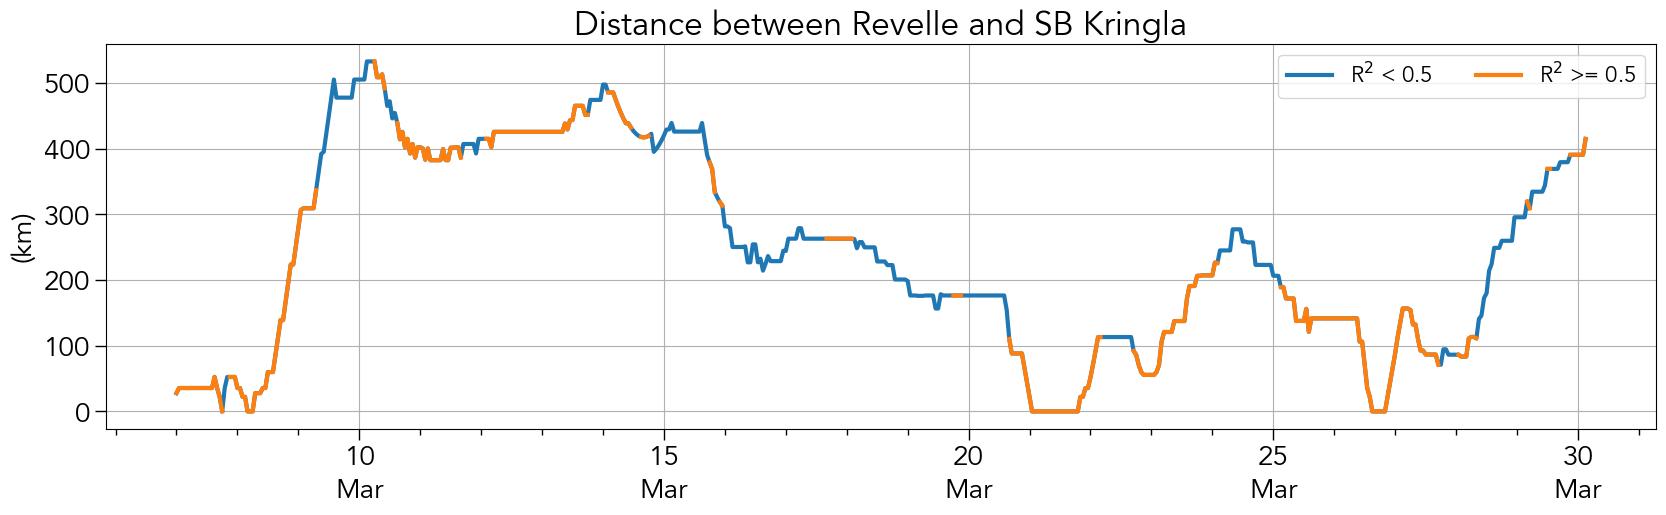

In [48]:
fig, ax = plt.subplots(figsize=(20,5))

lim = 0.5 

ship_corr['distance_grid'].plot(ax=ax,label=r'R$^{2}$ < ' + '{}'.format(lim),lw=3)
ship_corr['distance_grid'].where(ship_corr['t2mr2']>=lim).plot(ax=ax,c='C1',label=r'R$^{2}$ >= ' + '{}'.format(lim),lw=3)

ax.set(xlabel='',ylabel='(km)',title='Distance between Revelle and SB Kringla')
ax.grid()
ax.legend(ncol=2,fontsize=16)

fix_xticks([ax],ship_corr)

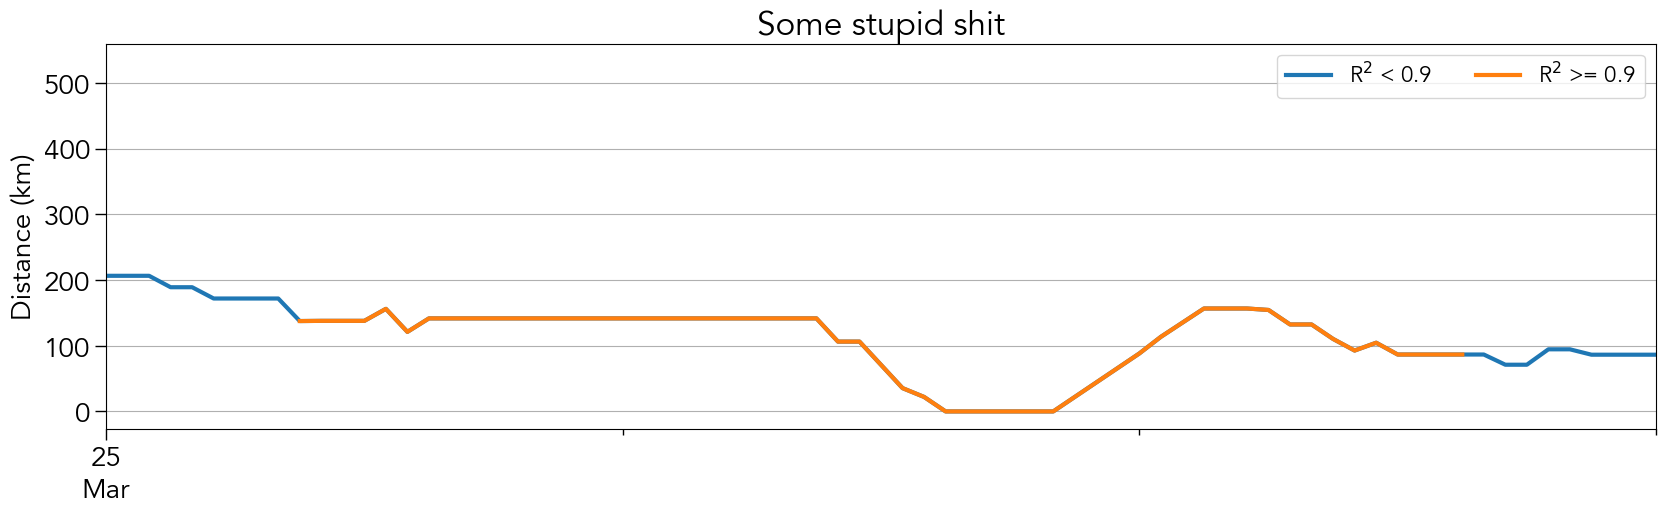

In [636]:
fig, ax = plt.subplots(figsize=(20,5))
ship_corr['distance_grid'].plot(ax=ax,label=r'R$^{2}$ < 0.9',lw=3)
#ship_corr.plot.scatter(x='time',y='distance_grid',hue='t2mr2',ec=None,alpha=1,ax=ax,vmin=0.9,cmap='Greys',)
ship_corr['distance_grid'].where(ship_corr['t2mr2']>=0.8).plot(ax=ax,c='C1',label=r'R$^{2}$ >= 0.9',lw=3)

ax.set(xlabel='', xlim=(np.datetime64('2023-03-25'),np.datetime64('2023-03-28')),ylabel='Distance (km)',title='Some stupid shit')
ax.grid()
ax.legend(ncol=2,fontsize=16)

fix_xticks([ax],ship_corr)

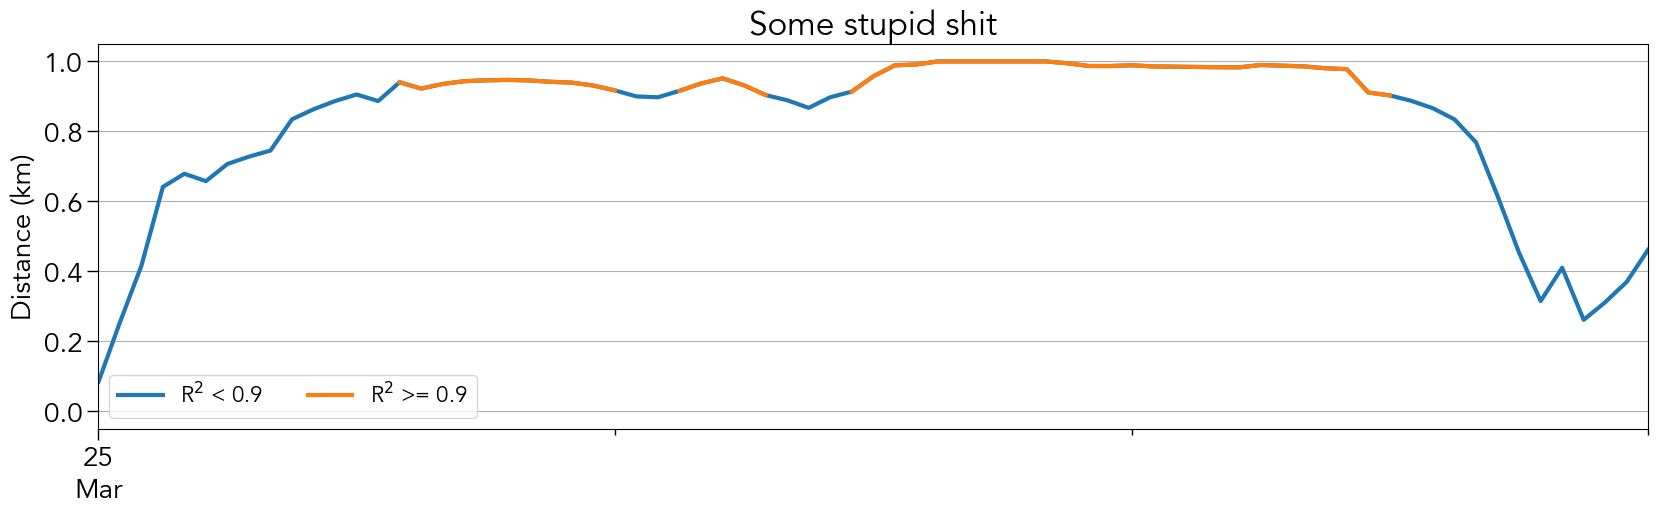

In [635]:
fig, ax = plt.subplots(figsize=(20,5))
ship_corr['t2mr2'].plot(ax=ax,label=r'R$^{2}$ < 0.9',lw=3)
#ship_corr.plot.scatter(x='time',y='distance_grid',hue='t2mr2',ec=None,alpha=1,ax=ax,vmin=0.9,cmap='Greys',)
ship_corr['t2mr2'].where(ship_corr['t2mr2']>=0.9).plot(ax=ax,c='C1',label=r'R$^{2}$ >= 0.9',lw=3)

ax.set(xlabel='', xlim=(np.datetime64('2023-03-25'),np.datetime64('2023-03-28')),ylabel='Distance (km)',title='Some stupid shit')
ax.grid()
ax.legend(ncol=2,fontsize=16)

fix_xticks([ax],ship_corr)

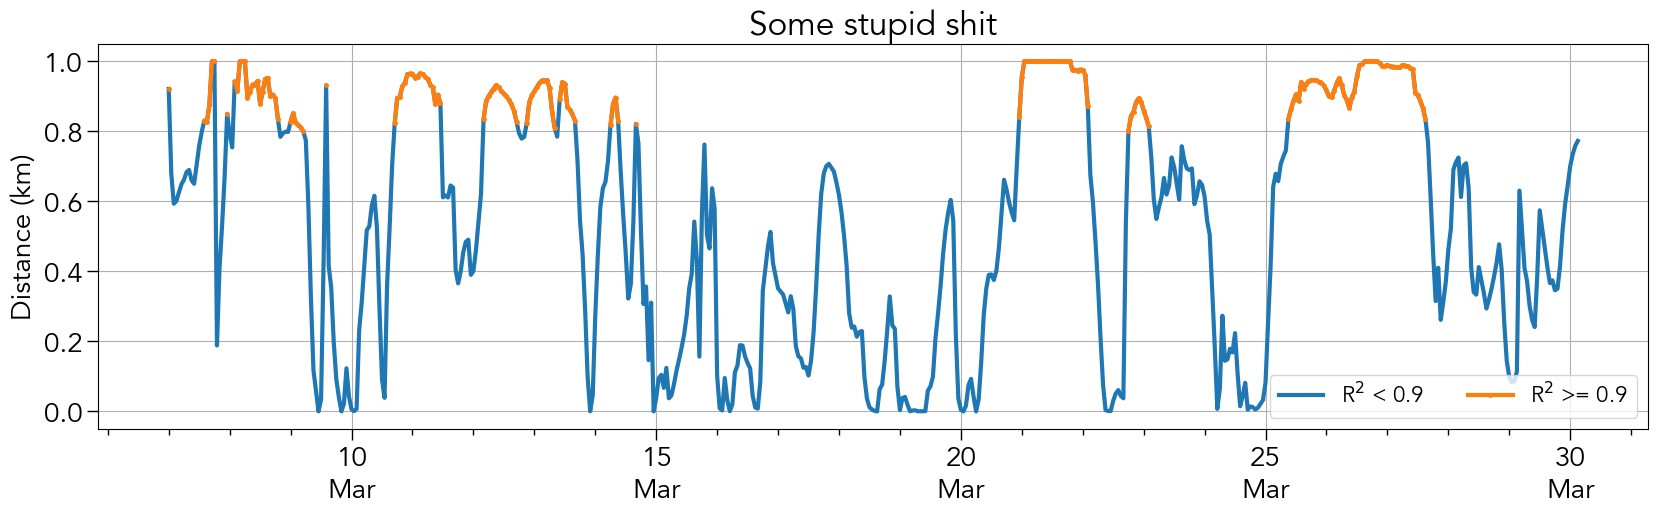

In [652]:
fig, ax = plt.subplots(figsize=(20,5))
ship_corr['t2mr2'].plot(ax=ax,label=r'R$^{2}$ < 0.9',lw=3)
#ship_corr.plot.scatter(x='time',y='distance_grid',hue='t2mr2',ec=None,alpha=1,ax=ax,vmin=0.9,cmap='Greys',)
ship_corr['t2mr2'].where(ship_corr['t2mr2']>=0.8).plot(ax=ax,c='C1',label=r'R$^{2}$ >= 0.9',lw=3, marker='.', ms=5)
# ship_corr.where(ship_corr['t2mr2']>=0.8).plot.scatter(x='time',y='t2mr2',ax=ax,c='C1',label=r'R$^{2}$ >= 0.9',zorder=2, ec=None)

ax.set(xlabel='',ylabel='Distance (km)',title='Some stupid shit')
ax.grid()
ax.legend(ncol=2,fontsize=16)

fix_xticks([ax],ship_corr)

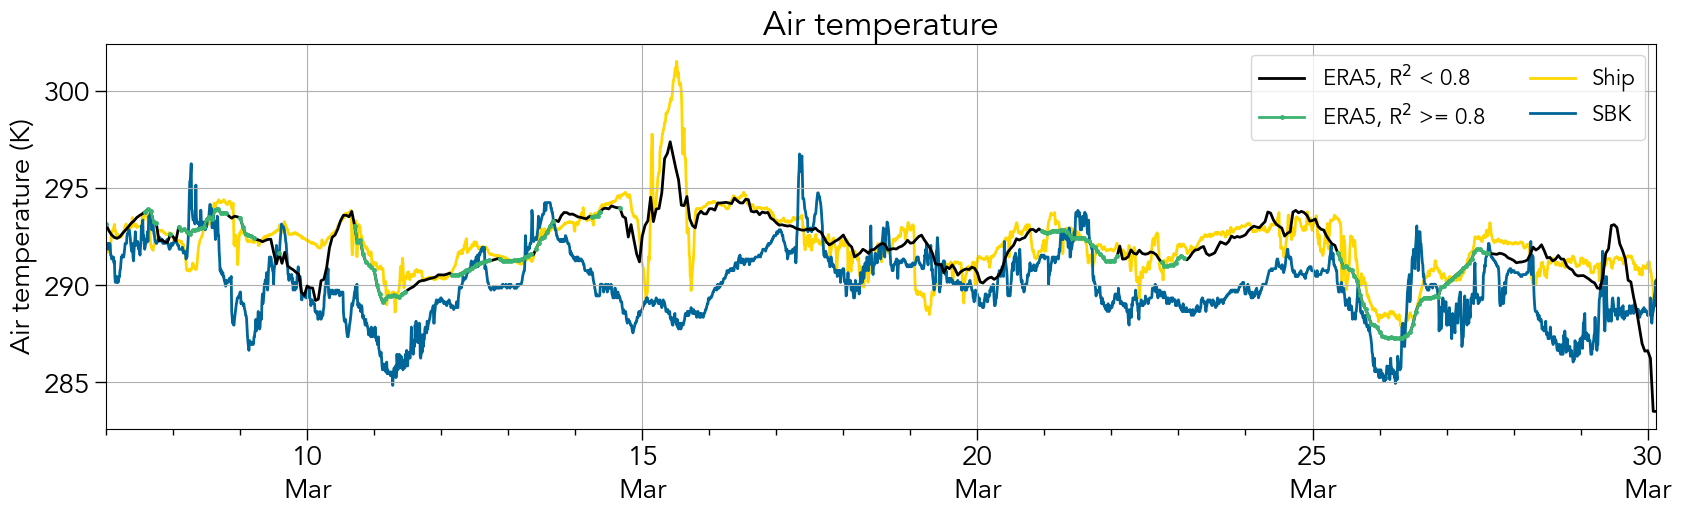

In [668]:
fig, ax = plt.subplots(figsize=(20,5))
ship_corr['t2m'].plot(ax=ax,label=r'ERA5, R$^{2}$ < 0.8',lw=2,c='k')
ship_corr['t2m'].where(ship_corr['t2mr2']>=0.8).plot(ax=ax,c='mediumseagreen',label=r'ERA5, R$^{2}$ >= 0.8',lw=2, marker='.', ms=5)

(ship['AT']+273.15).plot(ax=ax,c='gold',label='Ship',lw=2, zorder=1)
(sb_k['air_temp']+273.15).plot(ax=ax,c=kc,label='SBK',lw=2, zorder=1)


ax.set(xlabel='', xlim=(ship_corr.time[0],ship_corr.time[-1]),ylabel='Air temperature (K)',title='Air temperature')
ax.grid()
ax.legend(ncol=2,fontsize=16)

fix_xticks([ax],ship_corr)

In [654]:
ship

<xarray.Dataset>
Dimensions:  (time: 3629)
Coordinates:
  * time     (time) datetime64[ns] 2023-03-05 ... 2023-03-30T04:40:00
    doy      (time) float64 ...
    mday     (time) float64 ...
Data variables: (12/22)
    AT       (time) float64 ...
    BP       (time) float64 ...
    RH       (time) float64 ...
    RT       (time) float64 ...
    TW       (time) float64 ...
    TI       (time) float64 ...
    ...       ...
    TC_2     (time) float64 ...
    SA_2     (time) float64 ...
    SW       (time) float64 ...
    LW       (time) float64 ...
    LA       (time) float64 ...
    LO       (time) float64 ...

In [532]:
len(ship_corr['t2mr2'][idx])

0

{'whiskers': [<matplotlib.lines.Line2D at 0x5409986d0>,
 'caps': [<matplotlib.lines.Line2D at 0x543ad79d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x543938290>],
 'medians': [<matplotlib.lines.Line2D at 0x543ad4890>],
 'fliers': [<matplotlib.lines.Line2D at 0x543ad7510>],
 'means': []}

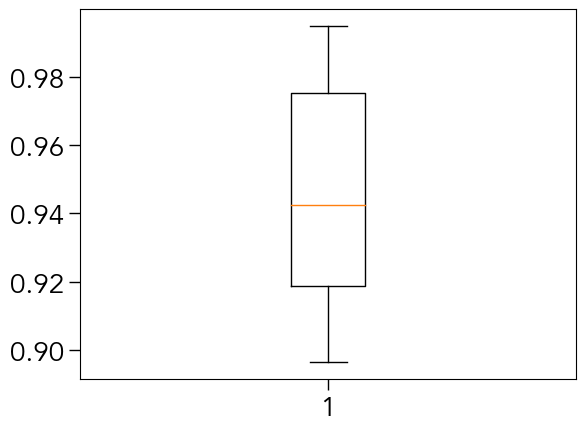

In [536]:
plt.boxplot(ship_corr['t2mr2'][idx],positions=)

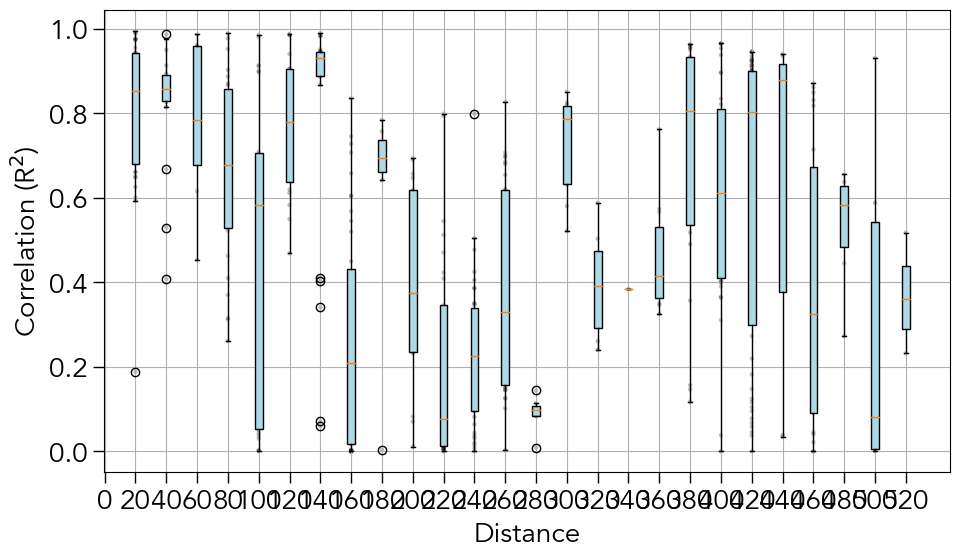

In [555]:
import numpy as np
import matplotlib.pyplot as plt

dl = 20
md = ship_corr['distance_grid'].max()

fig, ax = plt.subplots(figsize=(10, 6))

for i in np.arange(0, md + 1, dl):

    idx = ((ship_corr['distance_grid'] > i) & (ship_corr['distance_grid'] < i + dl))

    ax.boxplot(ship_corr['t2mr2'][idx], positions=[i], widths=5, labels=[int(i)], patch_artist=True, boxprops=dict(facecolor='lightblue'))

    ax.scatter([i] * len(ship_corr['t2mr2'][idx]), ship_corr['t2mr2'][idx], c='k', alpha=0.25, ec=None, s=10)

ax.set_xlabel('Distance')
ax.set_ylabel('Correlation (R$^{2}$)')

ax.grid()
plt.tight_layout()

plt.show()


In [ ]:
a

In [580]:
len(xtick_labels)

54

In [581]:
len(xticks)

53

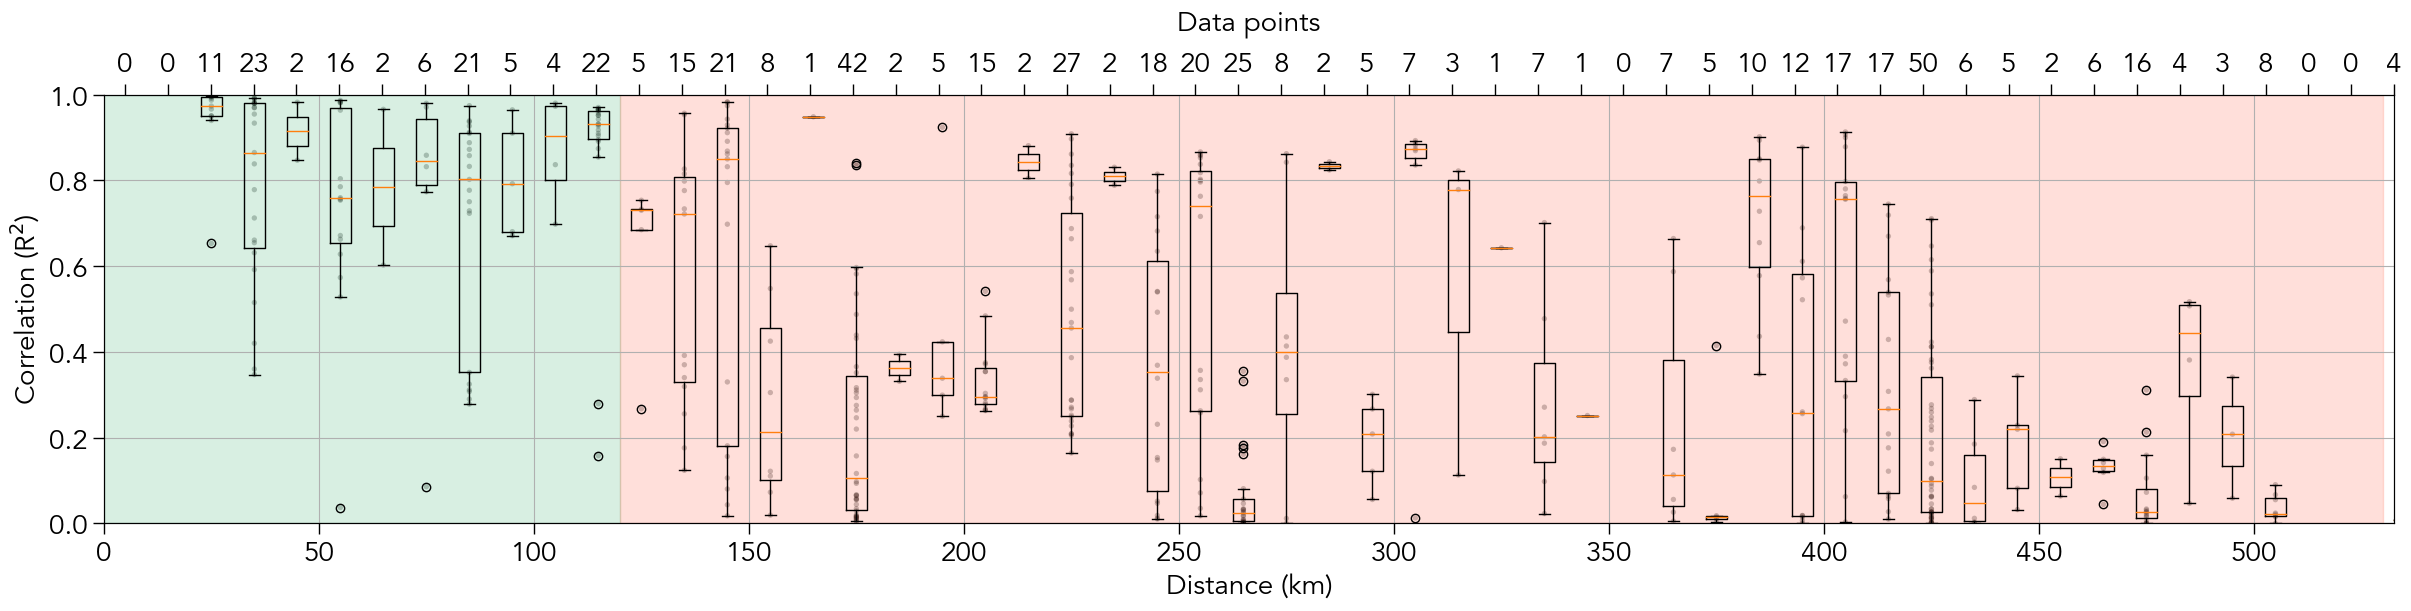

In [620]:
dl = 10
md = ship_corr['distance_grid'].max()
fig, ax = plt.subplots(figsize=(24,6),constrained_layout=True)

n = []

for i in np.arange(0, md+1, dl):

    idx = ((ship_corr['distance_grid'] > i) & (ship_corr['distance_grid'] <= i + dl))
    
    m = idx.sum().values
    n.append(m)    
    
    ax.boxplot(ship_corr['wscr2'][idx],positions=[i+dl/2],widths=5,labels=[int(i)])
    
    ax.scatter([i+dl/2]*len(ship_corr['wscr2'][idx]),ship_corr['wscr2'][idx],c='k',alpha=0.25,ec=None,s=15)

    
ax.grid()
ax.set(xlabel='Distance (km)', xlim=(0,md) ,ylabel='Correlation (R$^{2}$)', ylim=(0,1))

x_limits = ax.get_xlim()
# ax.fill([x_limits[0], x_limits[0], x_limits[1], x_limits[1], x_limits[0]], [0.8, 1, 1, 0.8, 0.8], color='mediumseagreen', alpha=0.2)
# ax.fill([x_limits[0], x_limits[0], x_limits[1], x_limits[1], x_limits[0]], [0, 0.8, 0.8, 0, 0], color='tomato', alpha=0.2)
# ax.axhline(0.8,c='k',ls='--',lw=2)

y_limits = ax.get_ylim()
ax.fill([0, 120, 120, 0, 0], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='mediumseagreen', alpha=0.2)
ax.fill([120, 530, 530, 120, 120], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='tomato', alpha=0.2)


# Create additional axes
top_ax = ax.twiny()  # Top x-axis

# Customize xticks and labels for the top axis
xticks = np.arange(0+dl/2, md+dl, dl)
xtick_labels = [str(x) for x in n]

top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

xticks = np.arange(0, md + dl, 50)  # Specify the positions for xticks
ax.set_xticks(xticks,labels=xticks.astype(int))  # Set xticks at specified positions


plt.show()

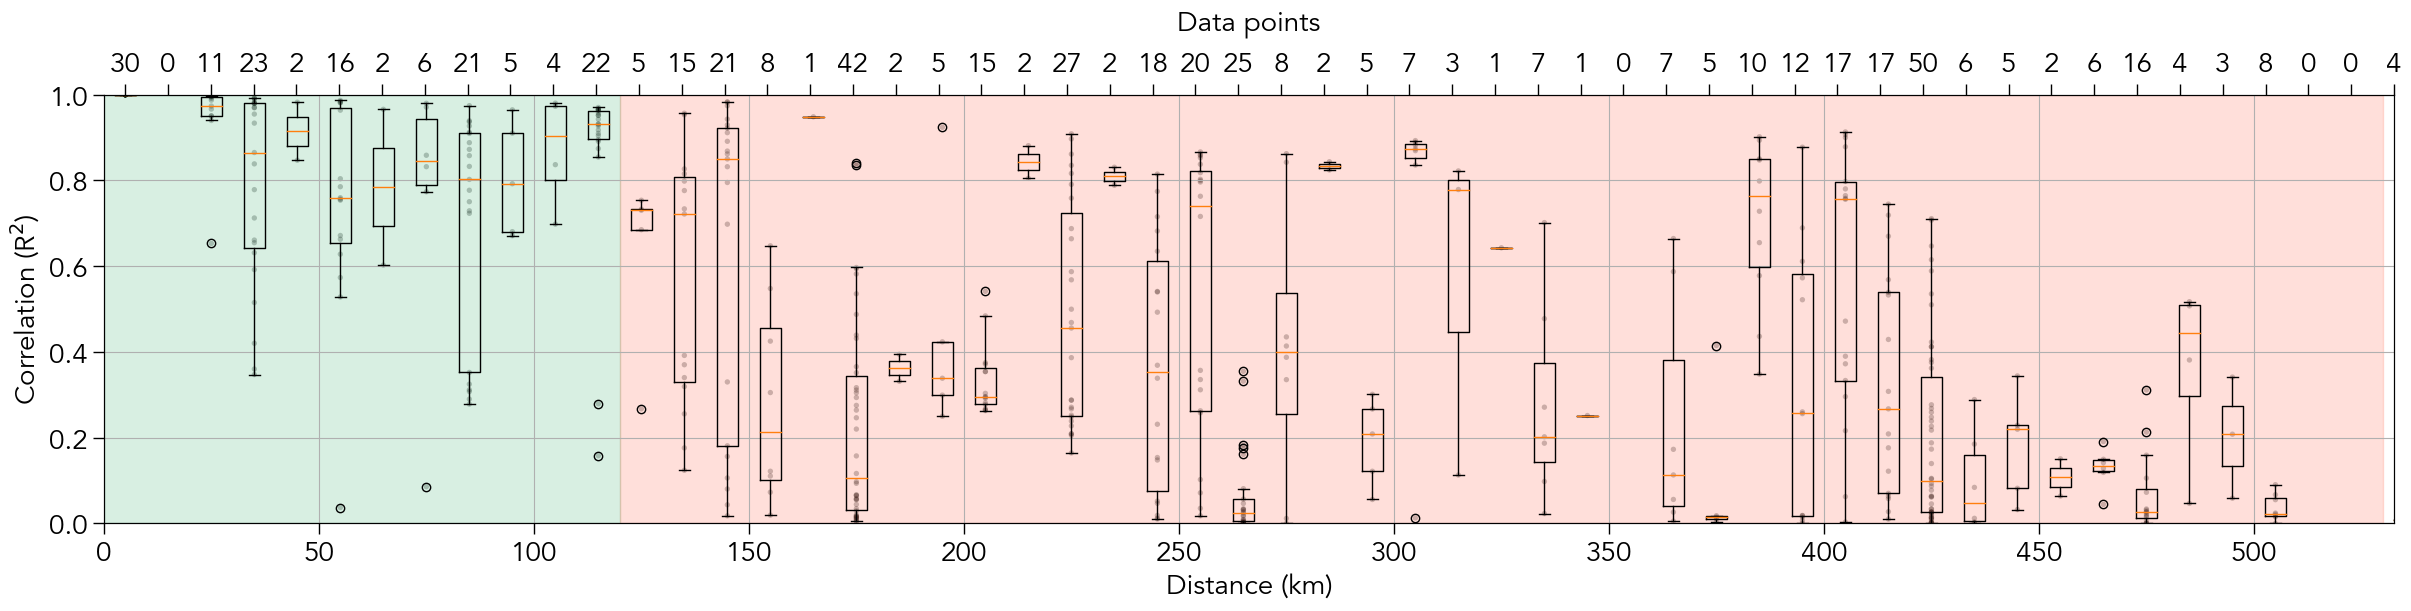

In [626]:
dl = 10
md = ship_corr['distance_grid'].max()
fig, ax = plt.subplots(figsize=(24,6),constrained_layout=True)

n = []

for i in np.arange(0, md+1, dl):

    idx = ((ship_corr['distance_grid'] >= i) & (ship_corr['distance_grid'] < i + dl))
    
    m = idx.sum().values
    n.append(m)    
    
    ax.boxplot(ship_corr['wscr2'][idx],positions=[i+dl/2],widths=5,labels=[int(i)])
    
    ax.scatter([i+dl/2]*len(ship_corr['wscr2'][idx]),ship_corr['wscr2'][idx],c='k',alpha=0.25,ec=None,s=15)

    
ax.grid()
ax.set(xlabel='Distance (km)', xlim=(0,md) ,ylabel='Correlation (R$^{2}$)', ylim=(0,1))

x_limits = ax.get_xlim()
# ax.fill([x_limits[0], x_limits[0], x_limits[1], x_limits[1], x_limits[0]], [0.8, 1, 1, 0.8, 0.8], color='mediumseagreen', alpha=0.2)
# ax.fill([x_limits[0], x_limits[0], x_limits[1], x_limits[1], x_limits[0]], [0, 0.8, 0.8, 0, 0], color='tomato', alpha=0.2)
# ax.axhline(0.8,c='k',ls='--',lw=2)

y_limits = ax.get_ylim()
ax.fill([0, 120, 120, 0, 0], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='mediumseagreen', alpha=0.2)
ax.fill([120, 530, 530, 120, 120], [y_limits[0], y_limits[0], y_limits[1], y_limits[1], y_limits[0]], color='tomato', alpha=0.2)


# Create additional axes
top_ax = ax.twiny()  # Top x-axis

# Customize xticks and labels for the top axis
xticks = np.arange(0+dl/2, md+dl, dl)
xtick_labels = [str(x) for x in n]

top_ax.set_xticks(xticks)
top_ax.set_xticklabels(xtick_labels)
top_ax.set_xlabel('Data points', labelpad=15)

xticks = np.arange(0, md + dl, 50)  # Specify the positions for xticks
ax.set_xticks(xticks,labels=xticks.astype(int))  # Set xticks at specified positions


plt.show()

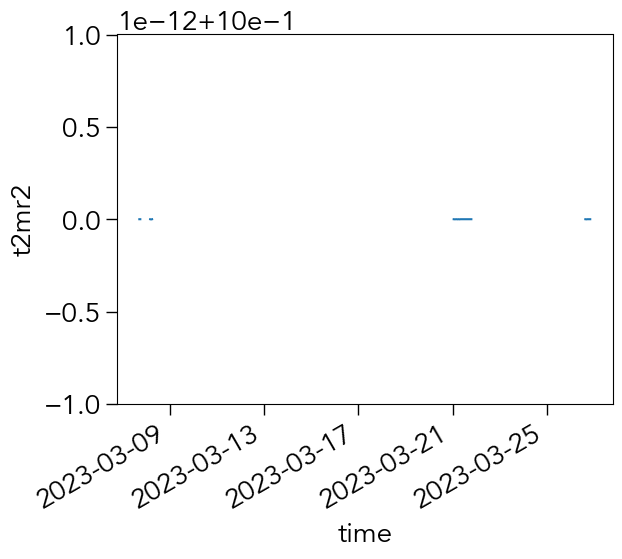

In [629]:
ship_corr.where(ship_corr['distance_grid'] == 0).t2mr2.plot()

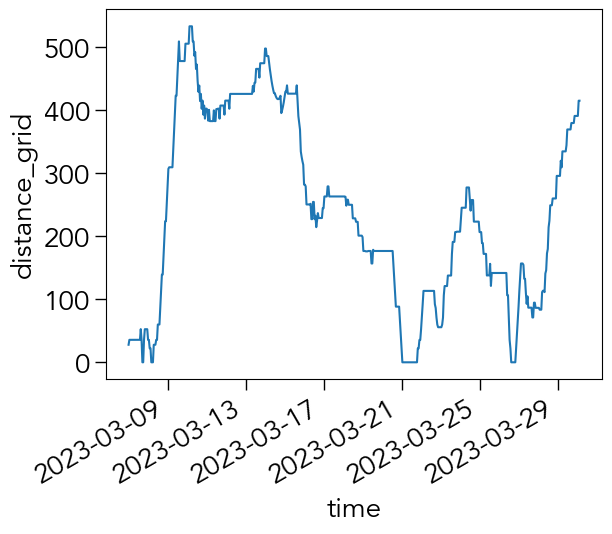

In [632]:
ship_corr.distance_grid.plot()

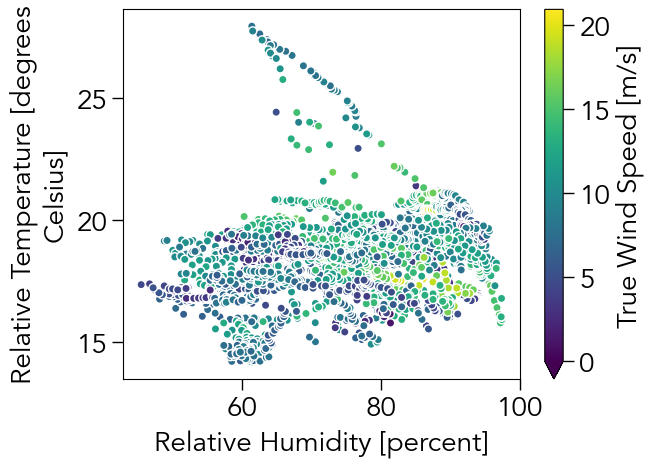

In [16]:
ship.plot.scatter(x='RH',y='RT',hue='TW',vmin=0)

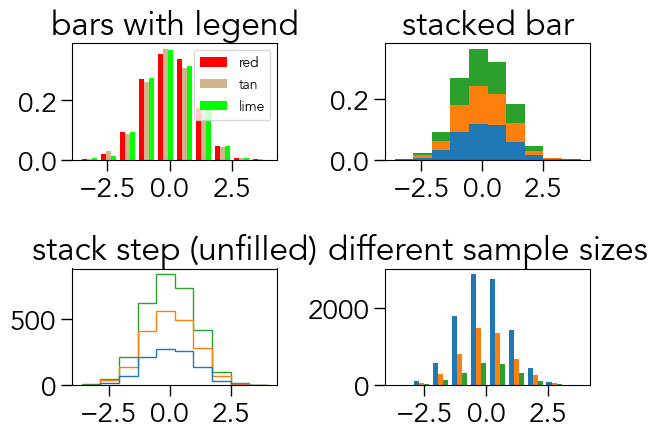

In [57]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()

In [58]:
x

array([[ 1.04930431,  0.86609917,  0.5511346 ],
       [ 1.72807779, -0.64928812, -0.47841958],
       [ 1.07788511,  0.96881033, -0.80934479],
       ...,
       [-0.79704914, -2.08514886, -0.34828915],
       [ 0.07050817,  0.39995811, -0.91531697],
       [-1.03880531, -0.56047396, -0.95100945]])